In [177]:
import pandas as pd 
import numpy as np
import random
import datetime
import sklearn.linear_model as skl_lm
import matplotlib.pyplot as plt 
import utilities as utils
import fractionalDiff as fd
import pickle
import scipy.stats as sps

In [178]:
inputs = pd.read_excel('data/returnsToWide.xlsx')
logicOutputs = pd.read_excel('data/logisticOutputs.xlsx')
tickers = inputs.columns[3:]
inputVariables = inputs.columns[2:]

In [179]:
inputs = pd.read_excel('../Data/candles.xlsx')
logicOutputs = pd.read_excel('../Data/bitcoin.xlsx')
tickers = ['indicator']
inputVariables = inputs.columns[2:]

maWindow = 11


# inputs['weekDay'] = inputs['date'].apply(lambda x: datetime.datetime.weekday(x))
# inputs['yearWeek'] = pd.DatetimeIndex(inputs['date']).isocalendar().week[0] * 10 + inputs['date'].apply(lambda x: datetime.datetime.weekday(x))

# for rollWndw in range(4, maWindow):
#     inputs[[f'mah{rollWndw}', f'mal{rollWndw}', f'mac{rollWndw}', f'mav{rollWndw}', f'maubb{rollWndw}', f'malbb{rollWndw}']] = inputs[['high', 'low', 'close', 'volume', 'UpperBB', 'LowerBB']].rolling(maWindow).mean()

# inputs.dropna(inplace = True)
# inputs.reset_index(inplace = True)
# logicOutputs = logicOutputs.iloc[(maWindow-1):, :]
# inputs.shape, logicOutputs.shape

In [180]:
#inputs['hReturn'] = inputs.close - inputs.open

inputs

,date,low,high,open,close,volume,ma_04,ma_06,ma_12,ma_16,ma_18,ma_20,ma_22,ma_24,ma_30,ma_48
0,2022-05-15 04:00:00,29436.06,29757.90,29685.11,29570.86,514.899875,29738.7675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-15 05:00:00,29450.01,29793.29,29570.84,29749.96,441.055380,29703.6150,29769.678333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-15 06:00:00,29673.06,29957.24,29749.96,29911.68,495.849997,29729.4025,29769.451667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-15 07:00:00,29741.94,30000.00,29911.69,29782.50,466.776920,29753.7500,29751.440000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-15 08:00:00,29510.01,29811.46,29782.39,29549.63,492.784858,29748.4425,29708.290000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,2022-05-26 20:00:00,29239.04,29560.00,29353.61,29426.04,700.060695,29495.4800,29484.826667,29256.887500,29317.771250,29367.630556,29402.0190,29422.621364,29451.697500,29495.332667,29587.242292
281,2022-05-26 21:00:00,29425.13,29657.10,29425.15,29550.00,489.347680,29477.9550,29515.946667,29289.290833,29309.588125,29353.793333,29397.2130,29424.735455,29441.569583,29493.768333,29587.063958
282,2022-05-26 22:00:00,29448.60,29640.27,29551.17,29469.99,532.720242,29450.5325,29500.318333,29319.414167,29298.381250,29339.129444,29381.8670,29411.835000,29429.902500,29491.573333,29584.769583
283,2022-05-26 23:00:00,29131.38,29527.41,29469.99,29166.06,796.268702,29403.0225,29424.645000,29335.918333,29265.338750,29310.525556,29350.2165,29390.014091,29415.842917,29474.297667,29575.178333


In [181]:
def TrendFollowOutput(data, date):
    prediction = 2.*((data.loc[data.date == date, 'close'].values - data.loc[data.date == date, 'open'].values)[0] >= 0) - 1.
    return prediction


In [201]:
accuracies = []
scoresByOrderLst = []
mlModels = []
pTrain = 0.7
window_0 = 4
nDaysInWindow = 1
deltaWindow = 5
cutoff = 1e-2
orders = np.linspace(0.1, 1.0, 10)

windows = range(window_0, window_0 + deltaWindow + 1)
#windows = [4, 9, 10, 12, 14, 16, 18, 20, 22, 24]

firstOrderDifferences = fd.FractionallyDifferentiateInputs(inputs, inputVariables, order = 1.0, thresholdVal = cutoff)[fd.findCutoff(1.0, cutoff, 1):].reset_index()

for order in orders:
    print(f'Differencing order: {order}')
    #lags = fd.findCutoff(order,cutoff,1)
    lags = 50
    transformedInputs = fd.FractionallyDifferentiateInputs(inputs, inputVariables, order = order, thresholdVal = cutoff)[lags:].reset_index()
    #transformedInputs['fdTrend'] = transformedInputs['close'] - transformedInputs['open']
    recapWithOrdersLst = []
    #transformedInputs['partOfDay'] = pd.DatetimeIndex(transformedInputs['date']).hour/window + 100 * pd.DatetimeIndex(transformedInputs['date']).isocalendar().week[0] + 10 * transformedInputs['date'].apply(lambda x: datetime.datetime.weekday(x))
    simRecapDatesLst = []

    for windowNumber, window in enumerate(windows):
        print(f'Recalibration window: {window}')
        trainScores = []
        testScores = []
        testScoresAlternativeMdl = []
        tickersLst = []
        trainOrderLst = []
        simulationDatesLst = []
        simulationDates = transformedInputs.date.unique()[(window):(transformedInputs.date.shape[0] - 1)]
        strategyReturnLst = []
        alternativeMdlStrategyReturnLst = []

        for simulationDate in simulationDates:
            
            startDateIdx = transformedInputs.index[transformedInputs.date == simulationDate][0] - window
            stopDateIdx = transformedInputs.index[transformedInputs.date == simulationDate][0] + 1
            
            startDate = transformedInputs.date[startDateIdx]
            testDate = transformedInputs.date[stopDateIdx - 1]
            stopDate = transformedInputs.date[stopDateIdx]

            for ticker in tickers:
                
                filteredReturn = inputs.loc[inputs.date == stopDate, 'close'] - inputs.loc[inputs.date == stopDate, 'open'] 
                inputsToScale = utils.FilterInputs(transformedInputs, startDate, stopDate)
                x, y = utils.SelectAndScale(inputsToScale, logicOutputs[lags:], startDate, stopDate, ticker, alreadyScaled = False)
                x = np.nan_to_num(x)
                xTrain, xTest, yTrain, yTest = utils.TestTrainSplit(x, y, window)
                
                if len(np.unique(yTrain)) < 2:
                    continue
                
                lrm = skl_lm.LogisticRegression(random_state=0, verbose = 0).fit(xTrain, yTrain)#beta =...

                if simulationDate == max(simulationDates):
                    mlModels.append({'order':order, 'calibrationWindow': window, 'model': lrm})

                trainScore = lrm.score(xTrain, yTrain)
                testScore = lrm.score(xTest, yTest)
                yPred = lrm.predict(xTest)

                yPredAlternativeMdl = TrendFollowOutput(inputs, simulationDate)
                trainScore = 0
                testScoreAlternativeMdl = 1. * (yTest == yPredAlternativeMdl)
                strategyReturn = yPred[0] * filteredReturn.values[0] 
                alternativeMdlStrategyReturn = yPredAlternativeMdl * filteredReturn.values[0] 

                trainScores.append(trainScore)
                testScores.append(testScore)
                testScoresAlternativeMdl.append(testScoreAlternativeMdl[0])
                simulationDatesLst.append(simulationDate)
                tickersLst.append(ticker)
                trainOrderLst.append(window)
                strategyReturnLst.append(strategyReturn)
                alternativeMdlStrategyReturnLst.append(alternativeMdlStrategyReturn)

        simRecapDf = pd.DataFrame(list(zip(trainOrderLst, simulationDatesLst, tickersLst, trainScores, testScores, testScoresAlternativeMdl, strategyReturnLst, alternativeMdlStrategyReturnLst)), columns = ['window', 'simulationDate', 'ticker', 'trainScore', 'testScore', 'alternativeMdlTestScore', 'strategyReturn', 'alternativeMdlStrategyReturn'])
        simRecapDatesLst.append(simRecapDf)

    simRecapWithWindowsDf = pd.concat(simRecapDatesLst)
    simRecapWithWindowsDf['order'] = order
    scoresByOrderLst.append(simRecapWithWindowsDf)

overallScores = pd.concat(scoresByOrderLst)
#overallScores.loc[overallScores.ticker.str.contains('JPY'), 'strategyReturn'] = overallScores.loc[overallScores.ticker.str.contains('JPY'), 'strategyReturn']/100.

Differencing order: 0.1
Recalibration window: 4
Recalibration window: 5
Recalibration window: 6
Recalibration window: 7
Recalibration window: 8
Recalibration window: 9
Differencing order: 0.2
Recalibration window: 4
Recalibration window: 5
Recalibration window: 6
Recalibration window: 7
Recalibration window: 8
Recalibration window: 9
Differencing order: 0.30000000000000004
Recalibration window: 4
Recalibration window: 5
Recalibration window: 6
Recalibration window: 7
Recalibration window: 8
Recalibration window: 9
Differencing order: 0.4
Recalibration window: 4
Recalibration window: 5
Recalibration window: 6
Recalibration window: 7
Recalibration window: 8
Recalibration window: 9
Differencing order: 0.5
Recalibration window: 4
Recalibration window: 5
Recalibration window: 6
Recalibration window: 7
Recalibration window: 8
Recalibration window: 9
Differencing order: 0.6
Recalibration window: 4
Recalibration window: 5
Recalibration window: 6
Recalibration window: 7
Recalibration window: 8


In [187]:
#alt model: fractional trend following
aggScores = overallScores.groupby(['order', 'window']).agg({'testScore':[np.size, np.mean, sps.skew, sps.kurtosis, np.std], \
    'strategyReturn': [np.sum], 'alternativeMdlTestScore':[np.mean, sps.skew, sps.kurtosis, np.std], 'alternativeMdlStrategyReturn': [np.sum]}).droplevel(level=[0], axis = 1).reset_index()
aggScores.columns = ['order', 'window', 'count', 'testScore', 'skew', 'kurt', 'testStd', 
    'strategyReturn', 'alternativeMdlTestScore', 'amSkew', 'amKurt', 'amtestStd', 'alternativeMdlStrategyReturn']

aggScores.sort_values(by = ['testScore'], ascending = False)

,order,window,count,testScore,skew,kurt,testStd,strategyReturn,alternativeMdlTestScore,amSkew,amKurt,amtestStd,alternativeMdlStrategyReturn
29,0.5,9,225,0.577778,-0.314945,-1.900810,0.495015,5473.20,0.520000,-0.080064,-1.993590,0.500714,-77.76
35,0.6,9,225,0.568889,-0.278209,-1.922600,0.496336,4832.96,0.520000,-0.080064,-1.993590,0.500714,-77.76
23,0.4,9,225,0.564444,-0.259946,-1.932428,0.496935,5605.46,0.520000,-0.080064,-1.993590,0.500714,-77.76
57,1.0,7,227,0.555066,-0.221612,-1.950888,0.498057,7161.45,0.519824,-0.079358,-1.993702,0.500711,288.83
41,0.7,9,225,0.551111,-0.205521,-1.957761,0.498490,4811.30,0.520000,-0.080064,-1.993590,0.500714,-77.76
6,0.2,4,209,0.545455,-0.182574,-1.966667,0.499125,3550.30,0.545455,-0.182574,-1.966667,0.499125,1498.92
58,1.0,8,226,0.544248,-0.177688,-1.968427,0.499144,5753.12,0.517699,-0.070841,-1.994982,0.500796,-165.32
28,0.5,8,226,0.544248,-0.177688,-1.968427,0.499144,3455.10,0.517699,-0.070841,-1.994982,0.500796,-165.32
17,0.3,9,225,0.542222,-0.169494,-1.971272,0.499325,5256.08,0.520000,-0.080064,-1.993590,0.500714,-77.76
0,0.1,4,209,0.540670,-0.163220,-1.973359,0.499540,3239.26,0.545455,-0.182574,-1.966667,0.499125,1498.92


In [184]:
#alt model: trend following
aggScores = overallScores.groupby(['order', 'window']).agg({'testScore':[np.size, np.mean, sps.skew, sps.kurtosis, np.std], \
    'strategyReturn': [np.sum], 'alternativeMdlTestScore':[np.mean, sps.skew, sps.kurtosis, np.std], 'alternativeMdlStrategyReturn': [np.sum]}).droplevel(level=[0], axis = 1).reset_index()
aggScores.columns = ['order', 'window', 'count', 'testScore', 'skew', 'kurt', 'testStd', 
    'strategyReturn', 'alternativeMdlTestScore', 'amSkew', 'amKurt', 'amtestStd', 'alternativeMdlStrategyReturn']

aggScores.sort_values(by = ['strategyReturn'], ascending = False)

,order,window,count,testScore,skew,kurt,testStd,strategyReturn,alternativeMdlTestScore,amSkew,amKurt,amtestStd,alternativeMdlStrategyReturn
57,1.0,7,227,0.555066,-0.221612,-1.950888,0.498057,7161.45,0.506608,-0.026434,-1.999301,0.501061,-586.59
3,0.1,7,227,0.528634,-0.114726,-1.986838,0.500283,6626.27,0.506608,-0.026434,-1.999301,0.501061,-586.59
32,0.6,6,226,0.522124,-0.088582,-1.992153,0.500619,5807.67,0.508850,-0.035404,-1.998747,0.501031,-119.87
58,1.0,8,226,0.544248,-0.177688,-1.968427,0.499144,5753.12,0.504425,-0.017700,-1.999687,0.501090,-1040.74
23,0.4,9,225,0.564444,-0.259946,-1.932428,0.496935,5605.46,0.506667,-0.026669,-1.999289,0.501070,-953.18
51,0.9,7,227,0.519824,-0.079358,-1.993702,0.500711,5589.55,0.506608,-0.026434,-1.999301,0.501061,-586.59
29,0.5,9,225,0.577778,-0.314945,-1.900810,0.495015,5473.20,0.506667,-0.026669,-1.999289,0.501070,-953.18
56,1.0,6,226,0.504425,-0.017700,-1.999687,0.501090,5472.53,0.508850,-0.035404,-1.998747,0.501031,-119.87
39,0.7,7,227,0.519824,-0.079358,-1.993702,0.500711,5472.37,0.506608,-0.026434,-1.999301,0.501061,-586.59
45,0.8,7,227,0.515419,-0.061703,-1.996193,0.500867,5365.69,0.506608,-0.026434,-1.999301,0.501061,-586.59


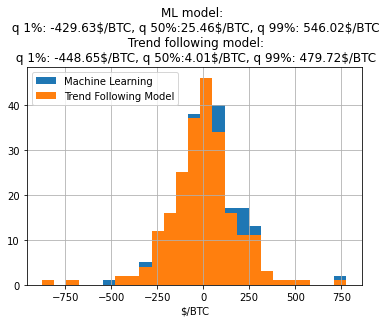

In [188]:
stats = overallScores.loc[(overallScores.order == orders[4]) & (overallScores.window == 9)]
stats.strategyReturn.hist(bins = 25)
stats.alternativeMdlStrategyReturn.hist(bins = 25)
plt.title(f'ML model: \n q 1%: {np.quantile(stats.strategyReturn, 0.01):.2f}$/BTC, q 50%:{stats.strategyReturn.median():.2f}$/BTC, q 99%: {np.quantile(stats.strategyReturn, 0.99):.2f}$/BTC\n Trend following model:\n q 1%: {np.quantile(stats.alternativeMdlStrategyReturn, 0.01):.2f}$/BTC, q 50%:{stats.alternativeMdlStrategyReturn.median():.2f}$/BTC, q 99%: {np.quantile(stats.alternativeMdlStrategyReturn, 0.99):.2f}$/BTC')
plt.xlabel('$/BTC')
plt.legend(['Machine Learning', 'Trend Following Model'])
plt.show()

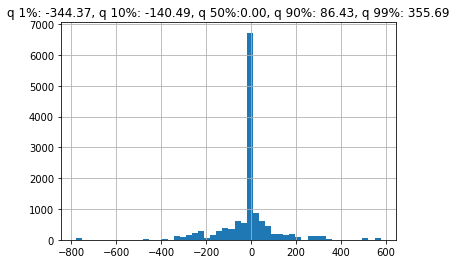

In [83]:
overallScores.alternativeMdlStrategyReturn.hist(bins = 50)
plt.title(f'q 1%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.01):.2f}, q 10%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.1):.2f}, q 50%:{overallScores.alternativeMdlStrategyReturn.median():.2f}, q 90%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.9):.2f}, q 99%: {np.quantile(overallScores.alternativeMdlStrategyReturn, 0.99):.2f}')
plt.show()

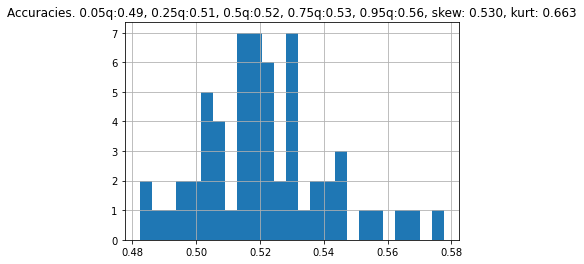

In [191]:
aggScores.testScore.hist(bins = 25)
#aggScores.coinFlipTestScore.hist(bins = 50)
plt.title(f'Accuracies. 0.05q:{np.quantile(aggScores.testScore, 0.05):.2f}, 0.25q:{np.quantile(aggScores.testScore, 0.25):.2f}, 0.5q:{aggScores.testScore.median():.2f}, 0.75q:{np.quantile(aggScores.testScore, 0.75):.2f}, 0.95q:{np.quantile(aggScores.testScore, 0.95):.2f}, skew: {aggScores.testScore.skew():.3f}, kurt: {aggScores.testScore.kurt():.3f}')
plt.show()

In [196]:
scoresToPlot = aggScores.groupby(['order']).agg({'alternativeMdlTestScore':np.mean, 'alternativeMdlStrategyReturn': np.mean, 'testScore':np.mean, 'strategyReturn':np.mean}).reset_index()
scoresToPlot

,order,alternativeMdlTestScore,alternativeMdlStrategyReturn,testScore,strategyReturn
0,0.1,0.524617,407.435,0.520817,2860.311667
1,0.2,0.524617,407.435,0.521621,2896.318333
2,0.3,0.524617,407.435,0.523647,3173.141667
3,0.4,0.524617,407.435,0.528088,3118.318333
4,0.5,0.524617,407.435,0.536339,3884.371667
5,0.6,0.524617,407.435,0.528168,3819.518333
6,0.7,0.524617,407.435,0.516148,4133.008333
7,0.8,0.524617,407.435,0.510976,3734.481667
8,0.9,0.524617,407.435,0.509973,3736.468333
9,1.0,0.524617,407.435,0.516321,4372.041667


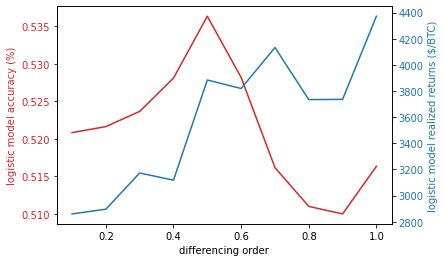

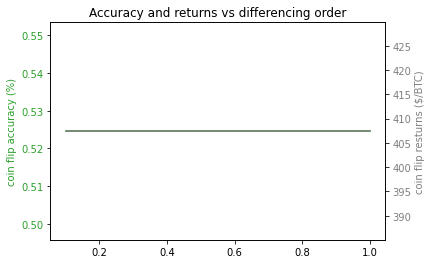

In [195]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('differencing order')
ax1.set_ylabel('logistic model accuracy (%)', color=color)
ax1.plot(scoresToPlot.order, scoresToPlot.testScore, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('logistic model realized returns ($/BTC)', color=color)  # we already handled the x-label with ax1
ax2.plot(scoresToPlot.order, scoresToPlot.strategyReturn, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.show()

fig2, ax3 = plt.subplots()

color = 'tab:green'
ax3.set_ylabel('coin flip accuracy (%)', color=color) 
ax3.plot(scoresToPlot.order, scoresToPlot.alternativeMdlTestScore, color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()
color = 'tab:grey'
ax4.set_ylabel('coin flip resturns ($/BTC)', color=color) 
ax4.plot(scoresToPlot.order, scoresToPlot.alternativeMdlStrategyReturn, color=color)
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(f'Accuracy and returns vs differencing order')
plt.show()

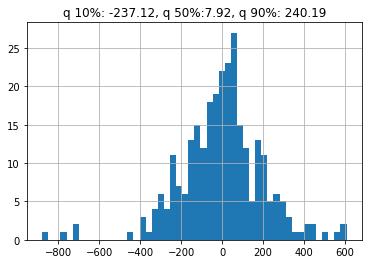

In [197]:
firstOrderDifferences.close.hist(bins = 50)
plt.title(f'q 10%: {np.quantile(firstOrderDifferences.close, 0.1):.2f}, q 50%:{firstOrderDifferences.close.median():.2f}, q 90%: {np.quantile(firstOrderDifferences.close, 0.9):.2f}') 
plt.show()

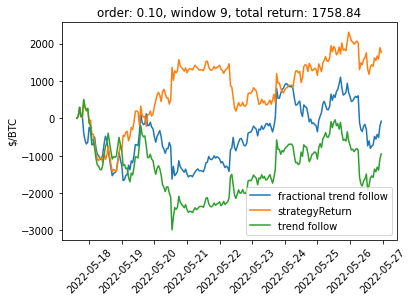

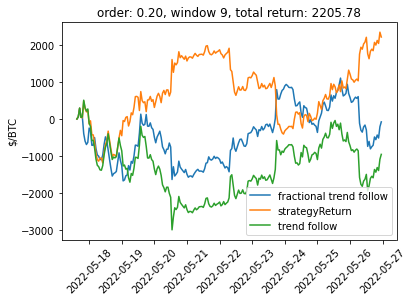

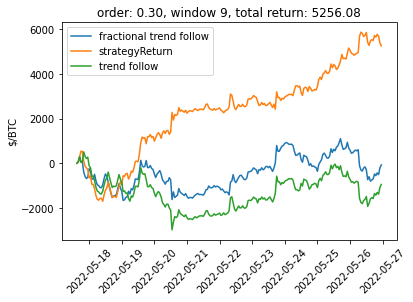

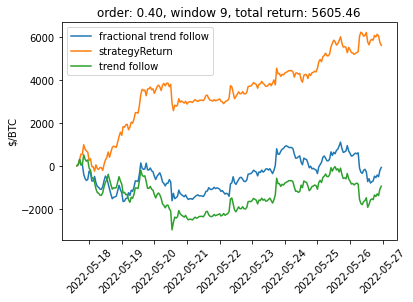

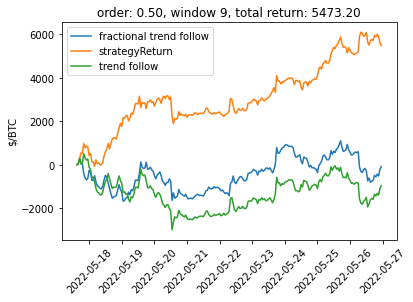

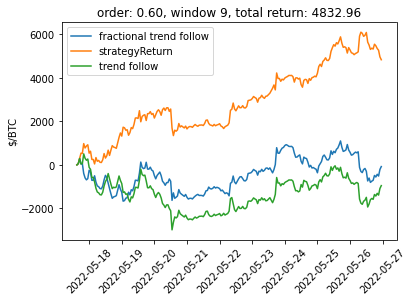

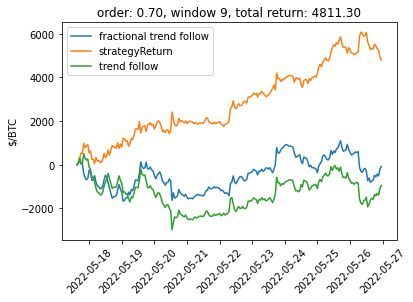

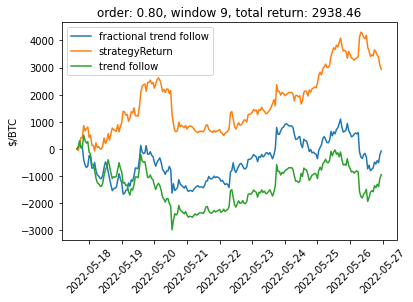

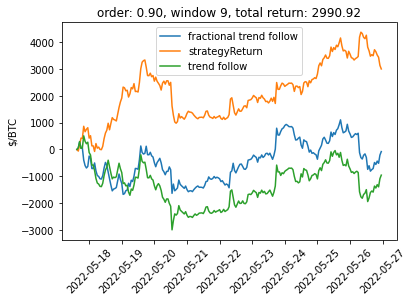

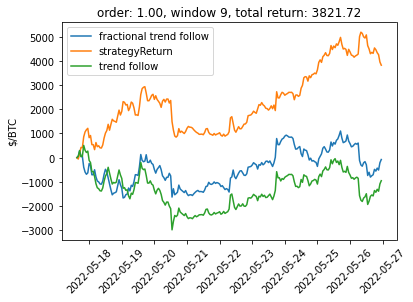

In [208]:
#for window in windows:
window = 9
#xy = scoresToPlot.loc[scoresToPlot.window == window]
for order in orders:
    #order = orders[7]
    strategyToPLot = overallScores.loc[(overallScores.window == window) & (overallScores.order == order)]
    strategyToPLotTF = overallScoresTrendFollow.loc[(overallScoresTrendFollow.window == window) & (overallScoresTrendFollow.order == order)]
    plt.plot(strategyToPLot.simulationDate, strategyToPLot.alternativeMdlStrategyReturn.cumsum())
    plt.plot(strategyToPLot.simulationDate, strategyToPLot.strategyReturn.cumsum())
    plt.plot(strategyToPLotTF.simulationDate, strategyToPLotTF.alternativeMdlStrategyReturn.cumsum())
    #plt.plot(scoresToPlot.order, scoresToPlot.realizedReturn)
    plt.title(f'order: {order:.2f}, window {window}, total return: {strategyToPLot.strategyReturn.sum():.2f}')
    plt.xticks(rotation = 45)
    plt.legend(['fractional trend follow', 'strategyReturn', 'trend follow'])
    plt.ylabel('$/BTC')
    plt.show()

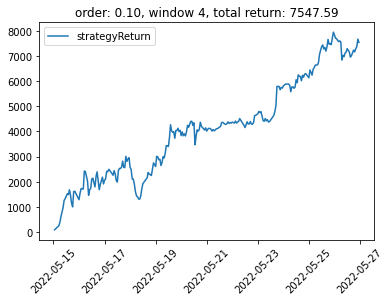

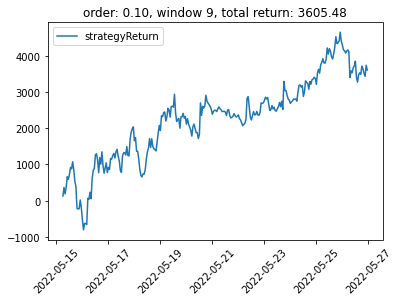

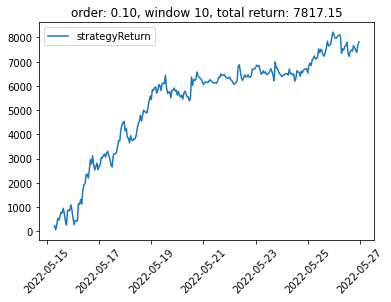

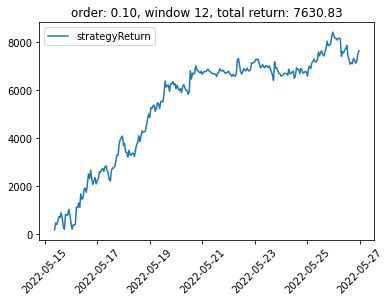

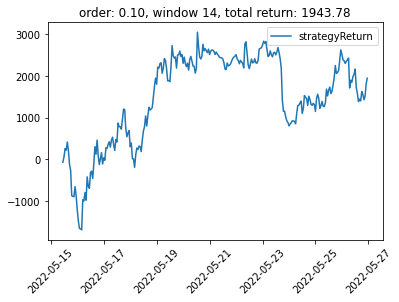

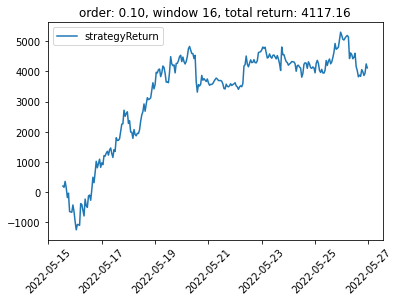

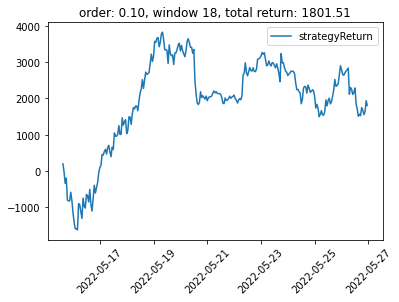

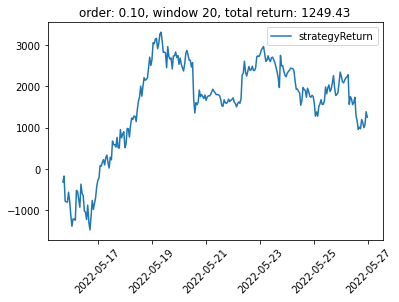

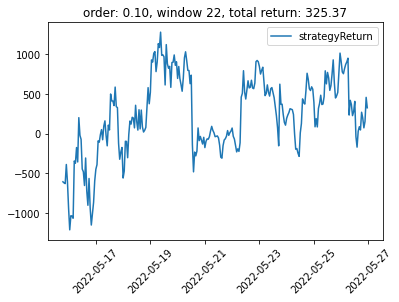

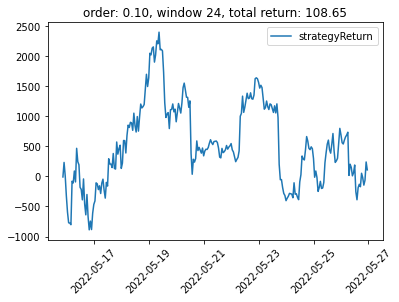

In [47]:
for window in windows:
    #xy = scoresToPlot.loc[scoresToPlot.window == window]
    #for order in orders:
    order = orders[0]
    strategyToPLot = overallScores.loc[(overallScores.window == window) & (overallScores.order == order)]
    plt.plot(strategyToPLot.simulationDate, strategyToPLot.strategyReturn.cumsum())
    #plt.plot(scoresToPlot.order, scoresToPlot.realizedReturn)
    plt.title(f'order: {order:.2f}, window {window}, total return: {strategyToPLot.strategyReturn.sum():.2f}')
    plt.xticks(rotation = 45)
    plt.legend(['strategyReturn'])
    plt.show()

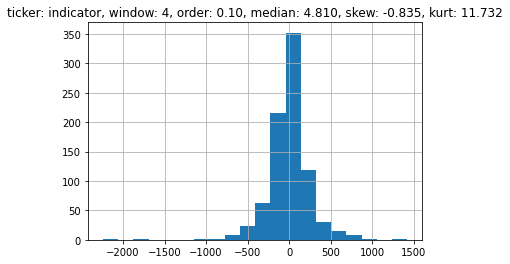

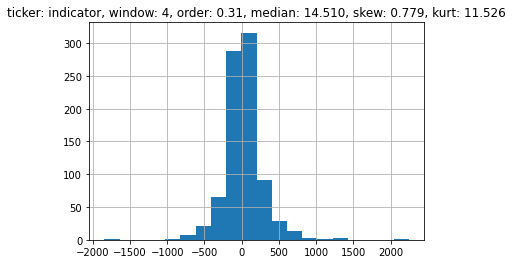

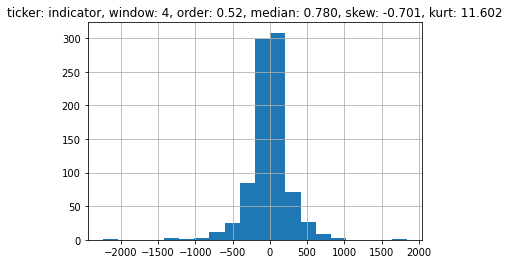

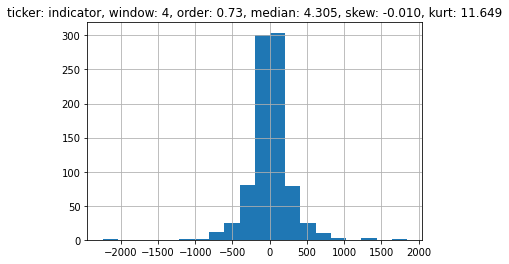

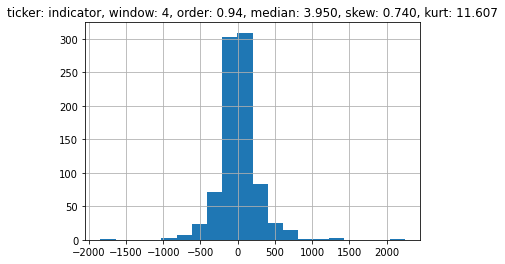

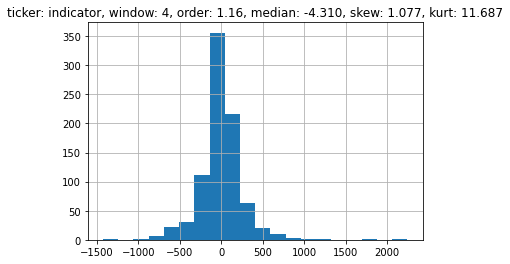

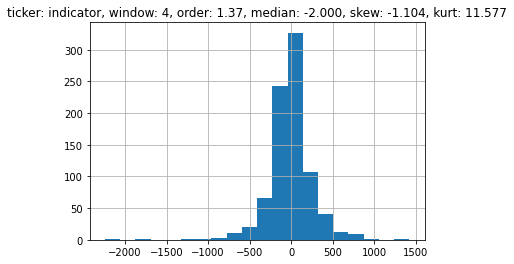

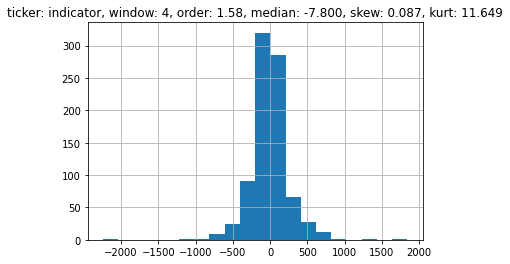

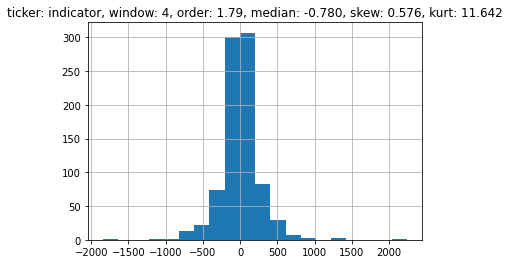

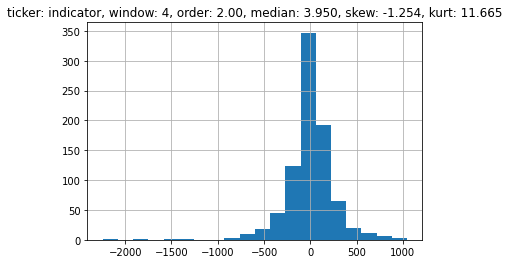

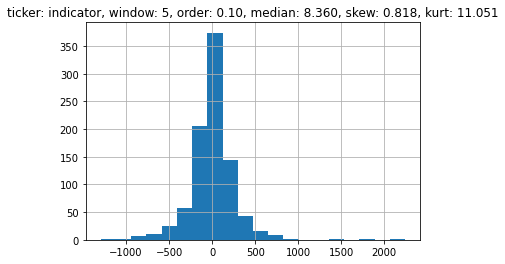

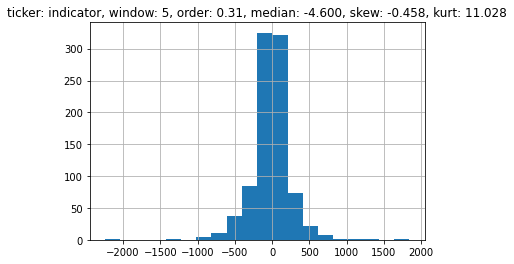

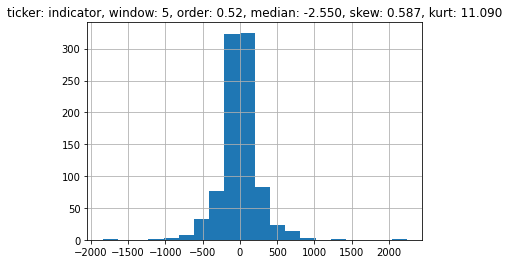

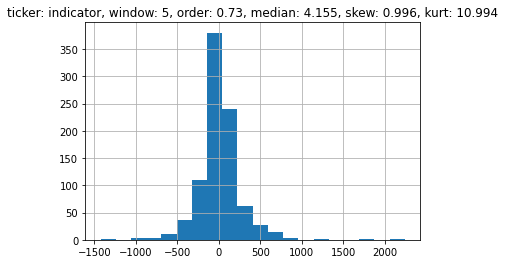

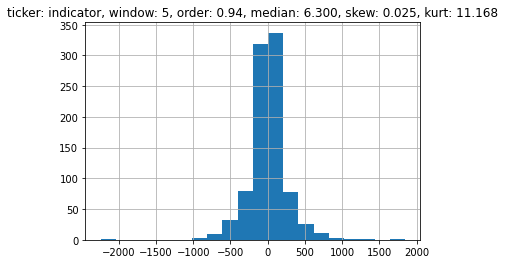

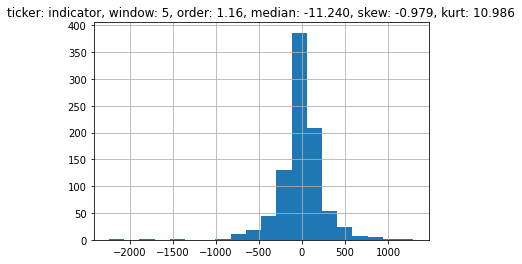

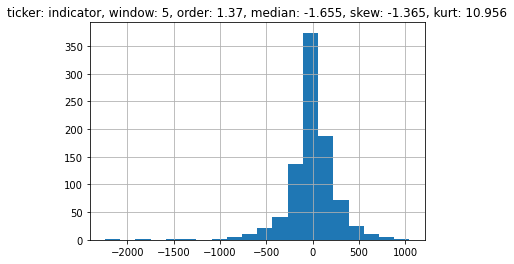

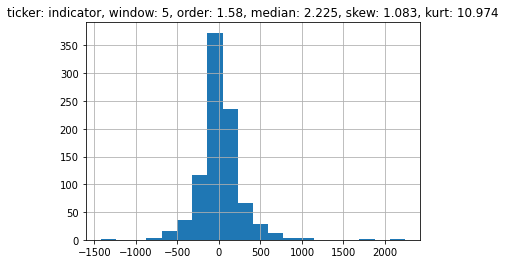

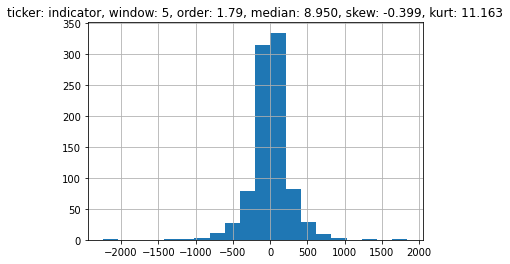

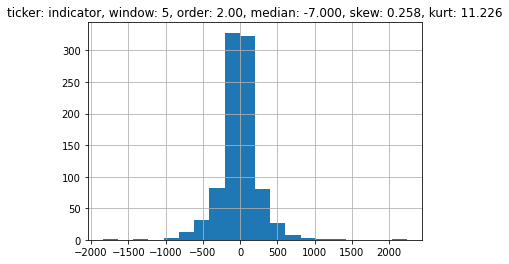

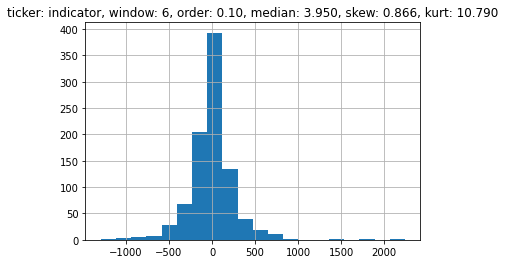

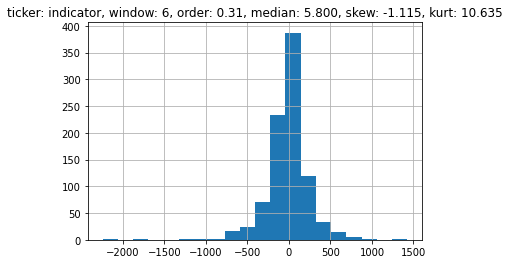

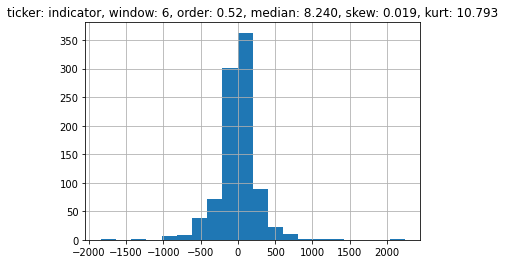

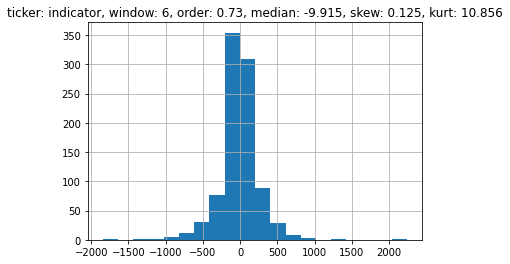

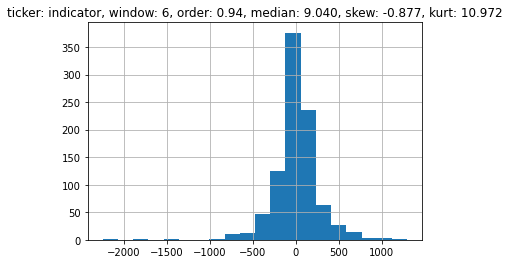

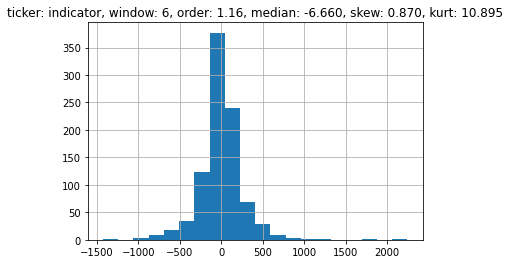

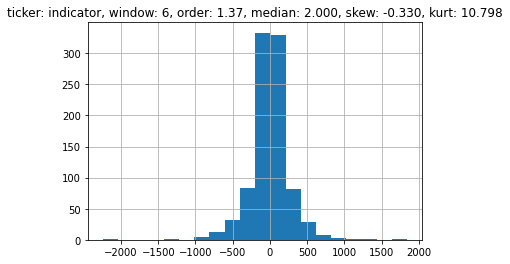

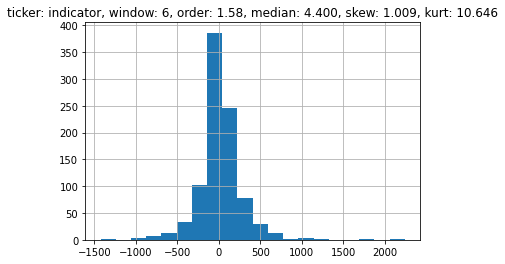

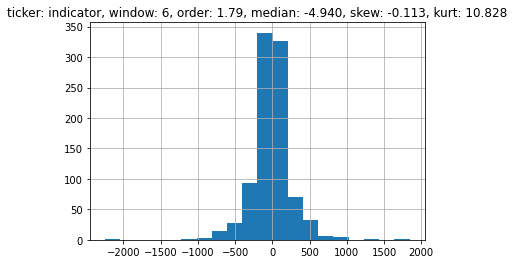

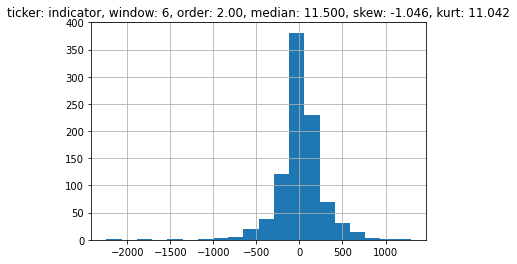

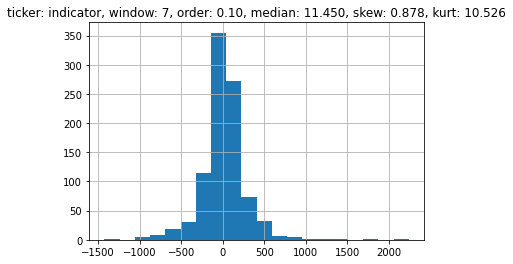

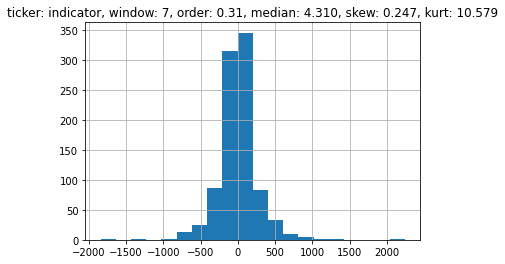

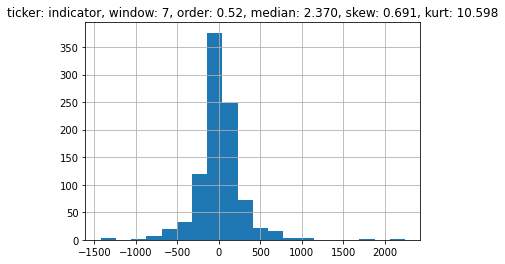

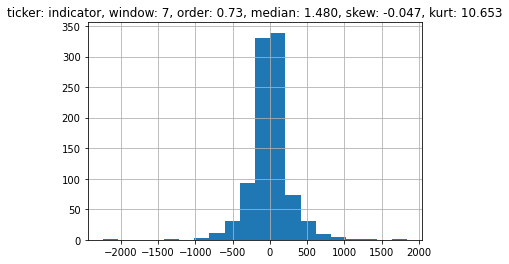

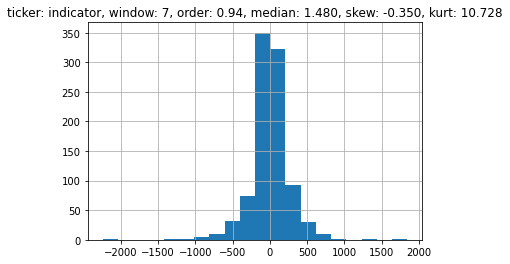

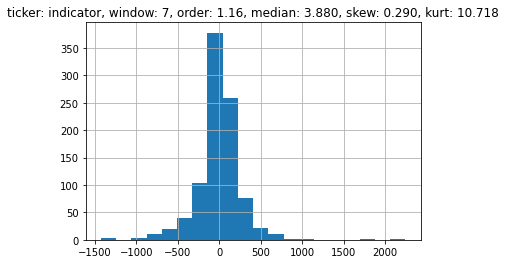

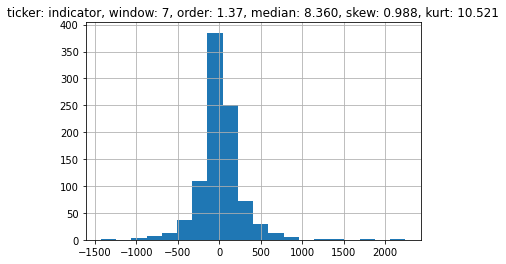

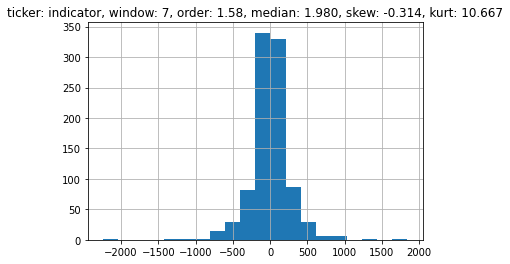

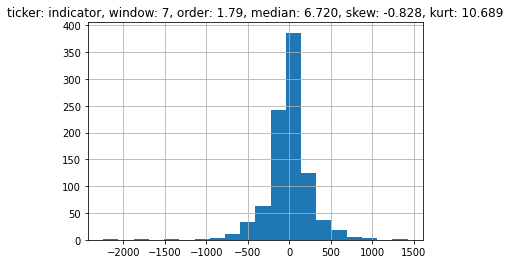

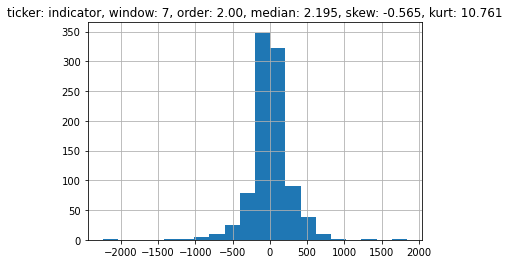

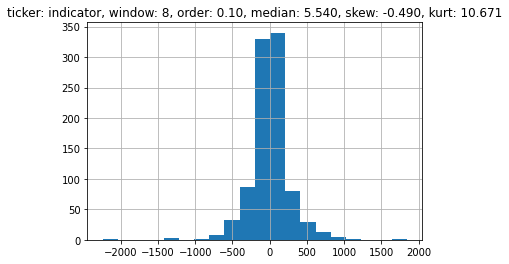

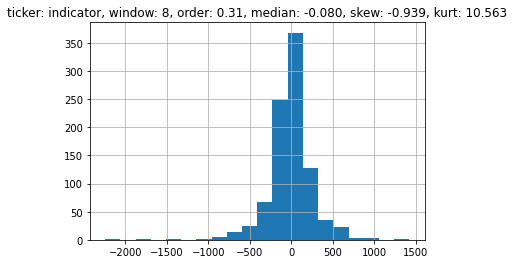

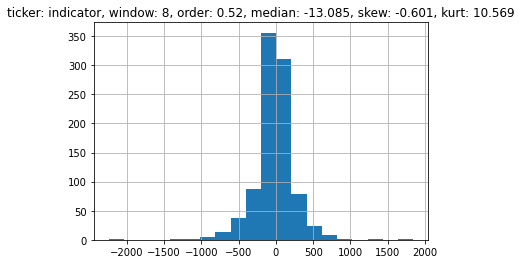

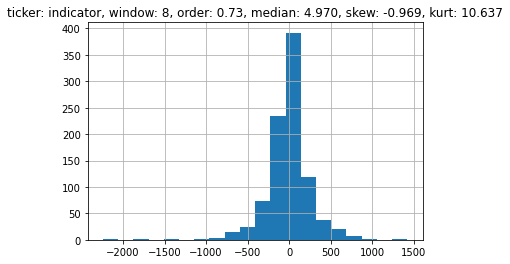

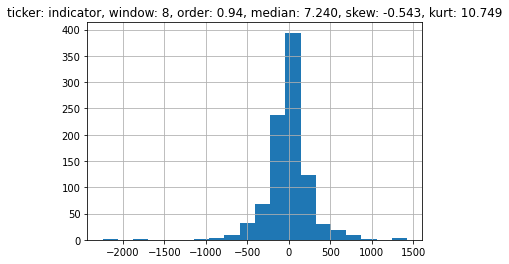

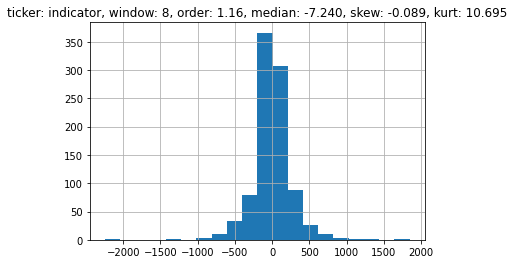

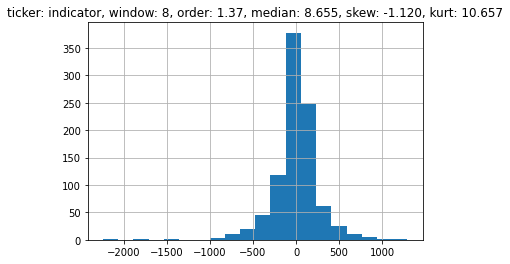

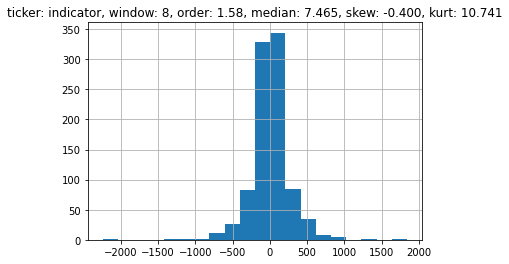

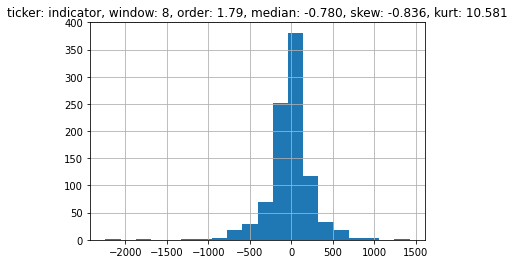

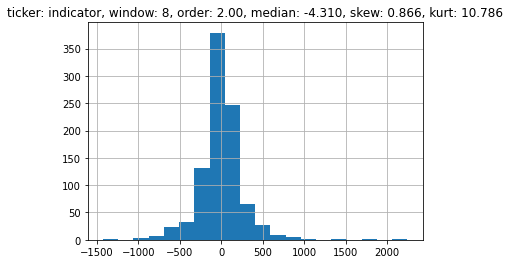

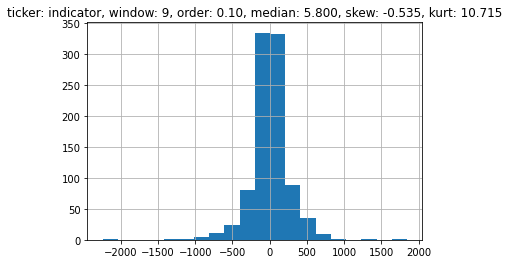

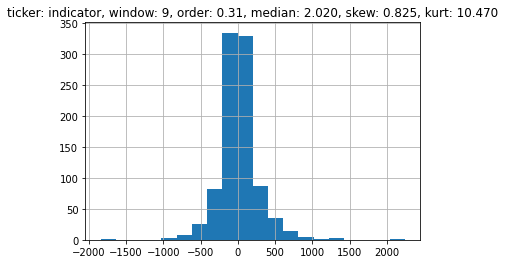

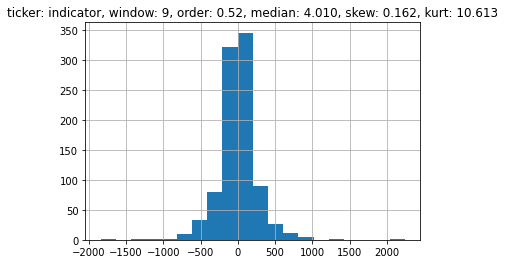

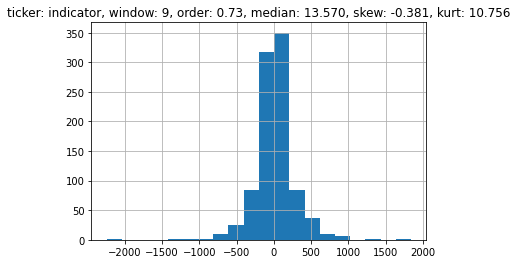

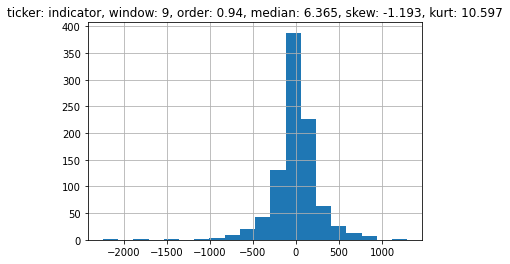

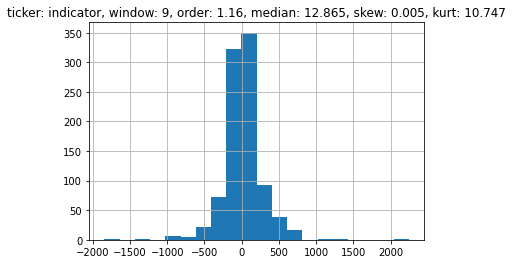

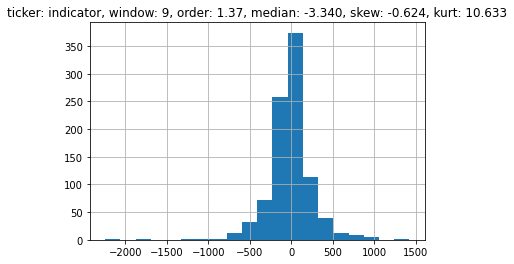

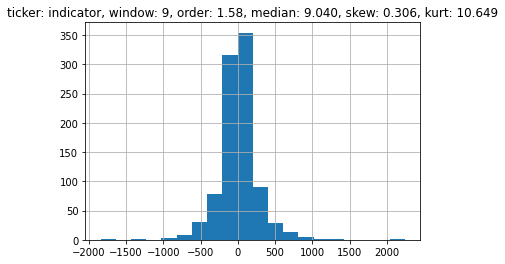

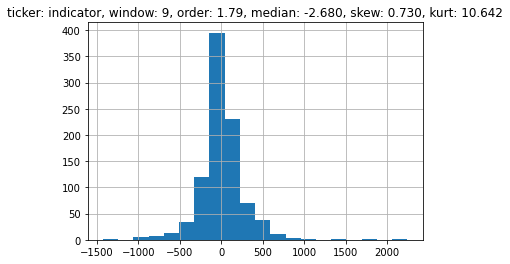

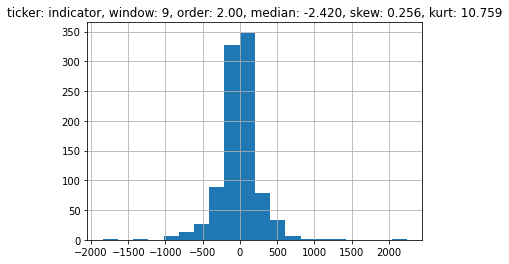

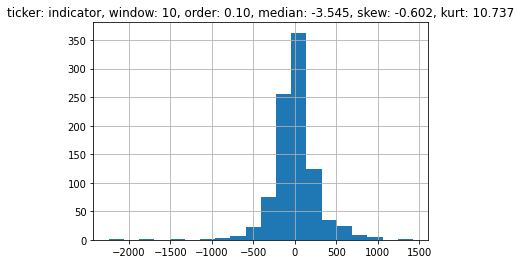

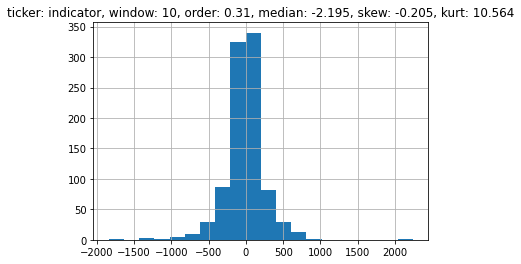

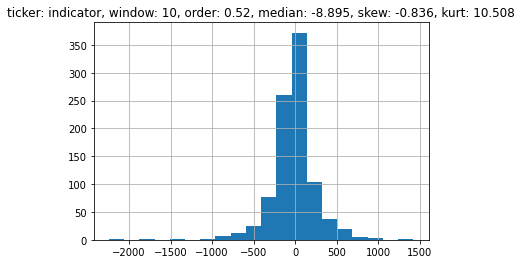

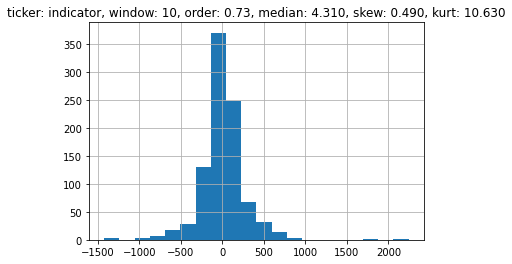

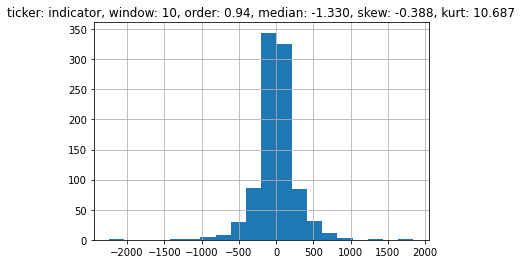

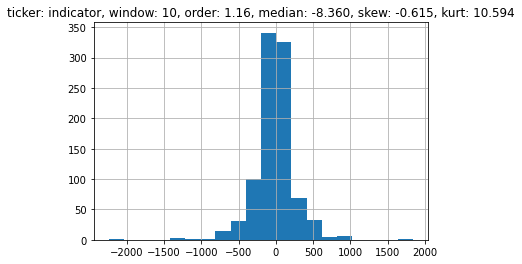

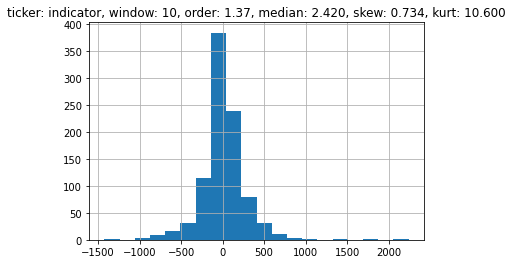

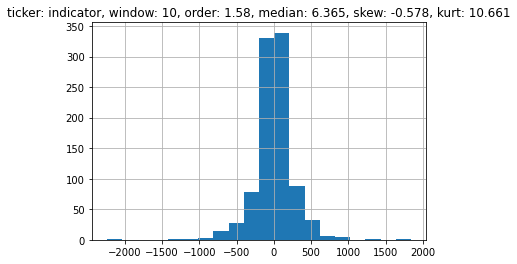

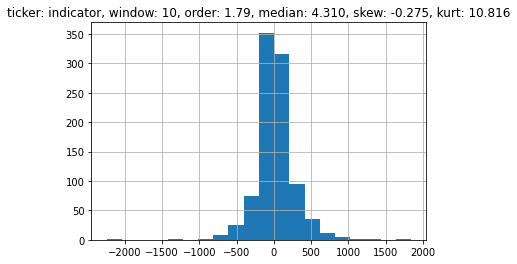

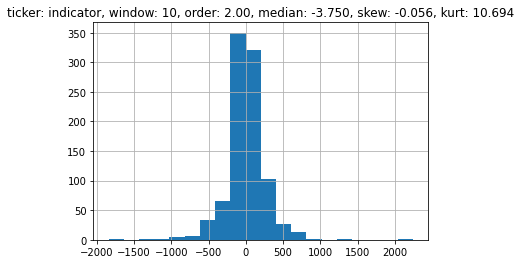

In [130]:
windowsToStudy = windows
ordersToStudy = orders
for ticker in tickers: 
    for window in windowsToStudy:
        for order in orders:
            x = overallScores.loc[(overallScores.ticker == ticker) & (overallScores.window == window) & (overallScores.order == order)].strategyReturn
            x.hist(bins = 20)
            plt.title(f'ticker: {ticker}, window: {window}, order: {order:.2f}, median: {x.median():.3f}, skew: {x.skew():.3f}, kurt: {x.kurt():.3f}')
            plt.show()

In [6]:
aggScores.loc[(aggScores['count']>=10000) & (aggScores['testScore']>0.5) & (aggScores['skew']<0.0) & (aggScores['kurt']<0.0), :].sort_values(by = ['testScore', 'skew', 'kurt'], ascending = [False, False, False])

,order,window,count,trainScore,trainStd,testScore,skew,kurt,testStd
5,0.2,8,46673,0.648148,0.053394,0.526316,-0.560071,-0.869726,0.101376
4,0.2,4,47634,0.648148,0.062108,0.523810,-0.508085,-0.918343,0.100964
2,0.1,9,43367,0.647727,0.057653,0.522727,-0.534762,-0.904500,0.100163
6,0.2,9,43140,0.652778,0.060372,0.521739,-0.464063,-0.976451,0.102170
10,0.3,9,43332,0.652174,0.063048,0.512195,-0.463088,-0.869342,0.101529
9,0.3,8,45866,0.653465,0.038801,0.509804,-0.376680,-0.864721,0.099711
1,0.1,8,48151,0.645833,0.044774,0.507463,-0.334003,-1.000671,0.093335


In [122]:
caseStudy = overallScores.loc[(overallScores.window == 10) & (overallScores.order == .8)].copy()

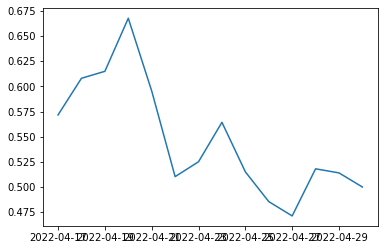

In [129]:
caseStudy['date'] = pd.to_datetime(caseStudy['simulationDate']).dt.date
xy = caseStudy.groupby(['date']).agg({'testScore':[np.mean]}).droplevel(level = [0], axis = 1).reset_index()

plt.plot(xy['date'], xy['mean'])
plt.show()

In [106]:
caseStudy = overallScores.loc[(overallScores.window == 10) & (overallScores.order == .8)].copy()
caseStudy

higerScores = caseStudy.loc[(caseStudy.testScore>=0.58)]
lowerScores = caseStudy.loc[(caseStudy.testScore<0.58)]

higerScores.testScore.median(), lowerScores.testScore.median()

(0.6285714285714286, 0.5135135135135135)

In [36]:
overallScores

,window,simulationDate,ticker,trainScore,testScore,strategyReturn,order
0,4,2022-04-15 19:00:00,indicator,1.0,0.0,-83.25,0.01
1,4,2022-04-15 20:00:00,indicator,1.0,1.0,29.38,0.01
2,4,2022-04-15 21:00:00,indicator,1.0,1.0,38.12,0.01
3,4,2022-04-15 22:00:00,indicator,1.0,1.0,82.31,0.01
4,4,2022-04-16 02:00:00,indicator,1.0,1.0,86.42,0.01
...,...,...,...,...,...,...,...
295,4,2022-04-29 19:00:00,indicator,1.0,0.0,-241.12,1.00
296,4,2022-04-29 20:00:00,indicator,1.0,1.0,0.78,1.00
297,4,2022-04-29 21:00:00,indicator,1.0,0.0,-48.67,1.00
298,4,2022-04-29 22:00:00,indicator,1.0,0.0,-16.18,1.00


In [37]:
orders

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

300


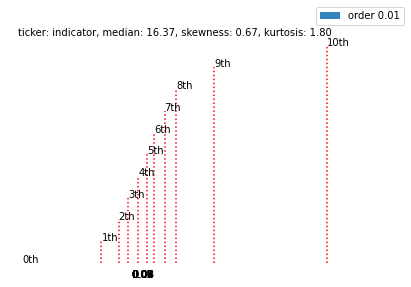

300


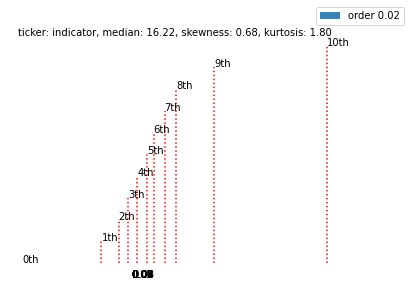

299


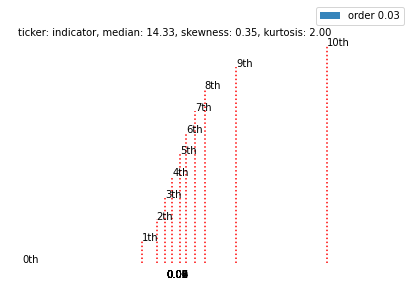

298


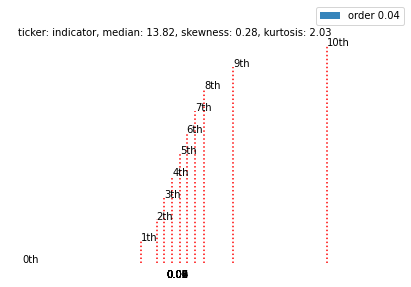

297


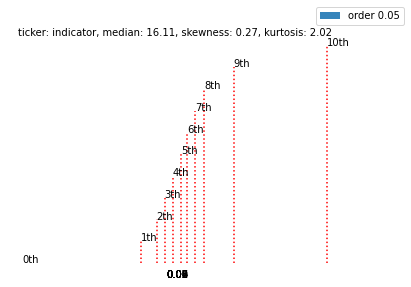

296


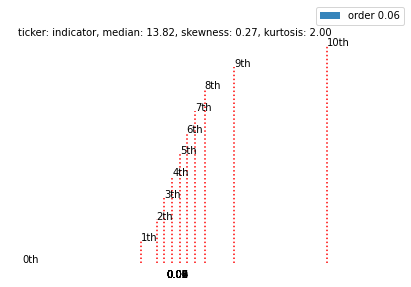

296


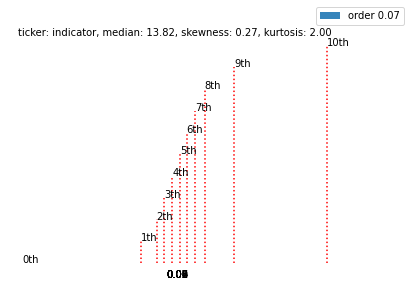

296


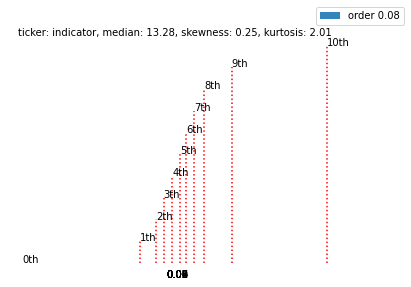

296


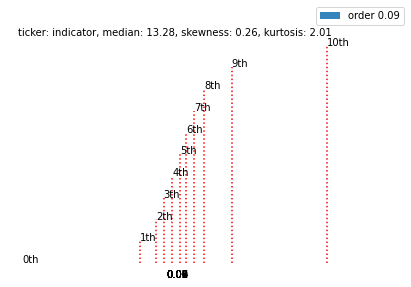

296


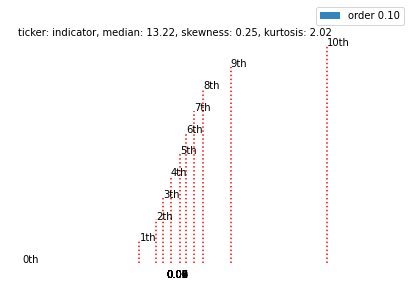

296


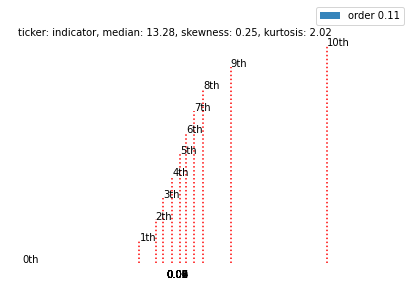

296


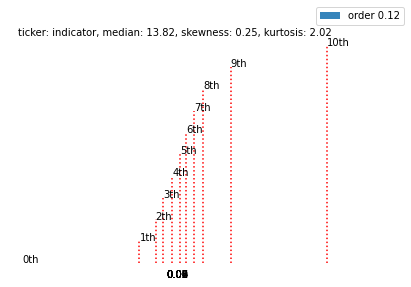

295


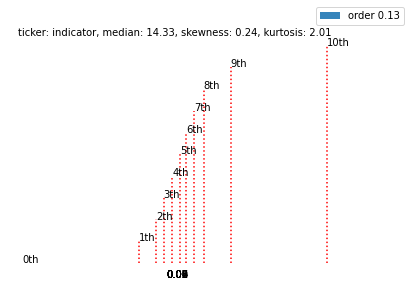

295


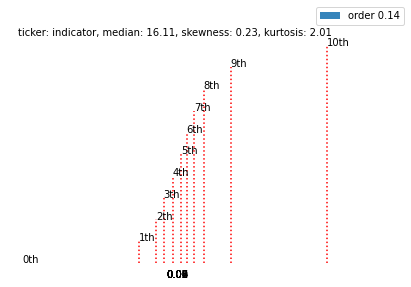

295


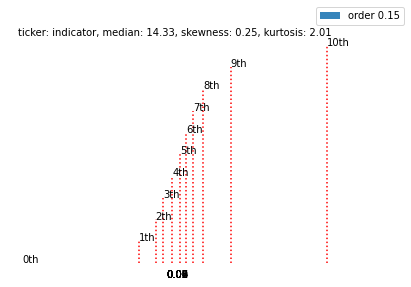

295


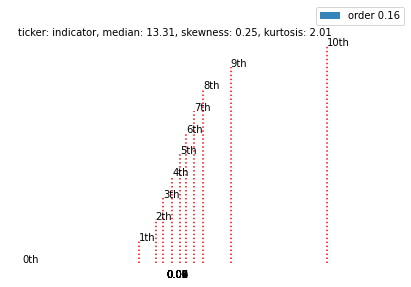

294


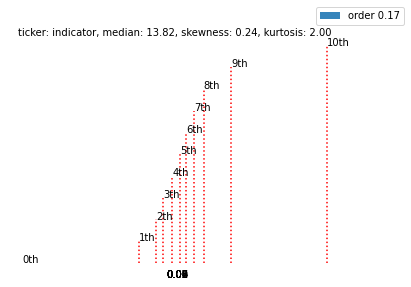

294


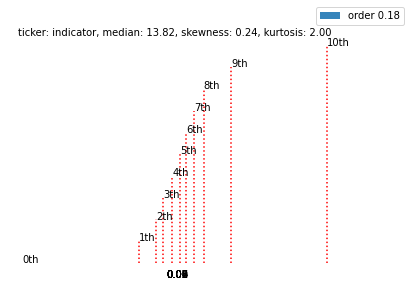

294


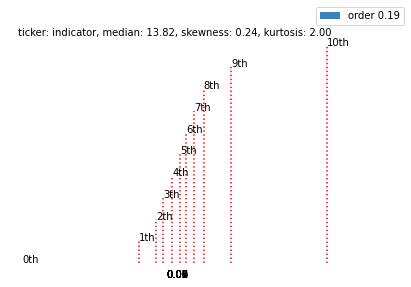

294


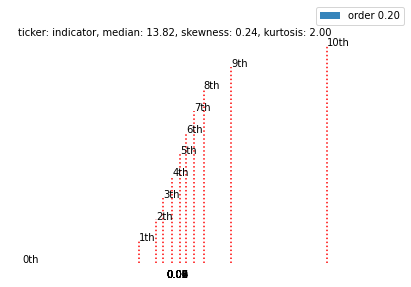

294


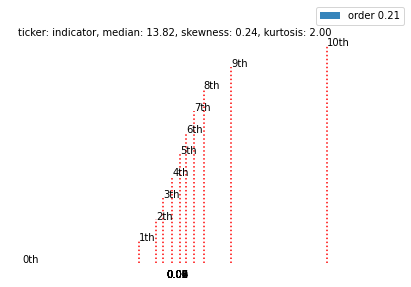

293


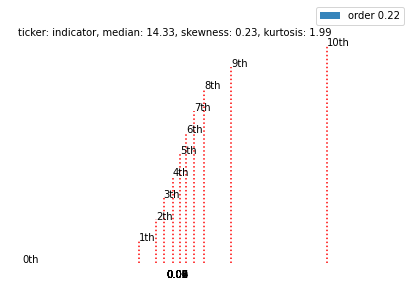

293


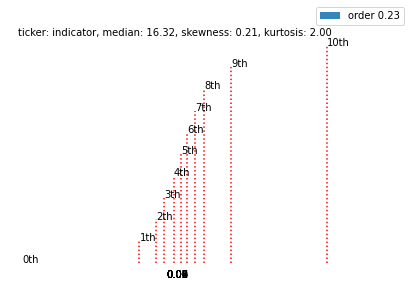

293


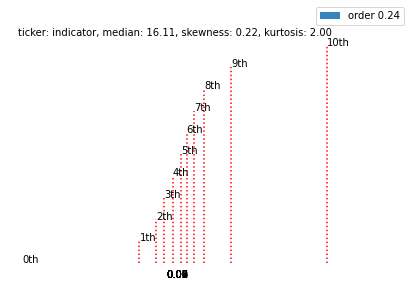

293


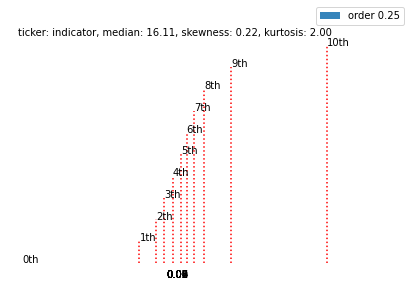

293


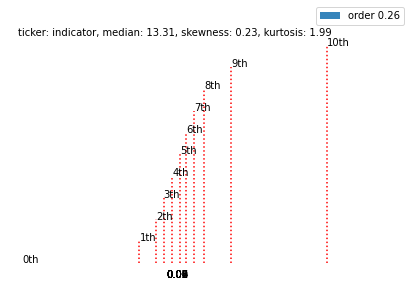

293


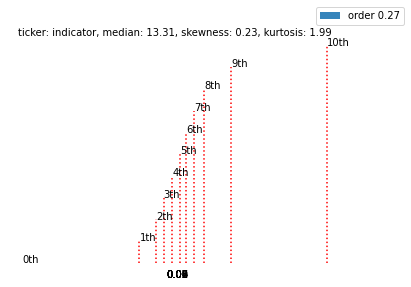

293


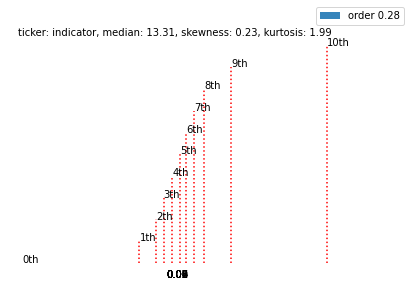

293


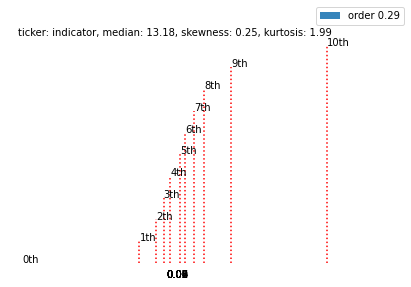

293


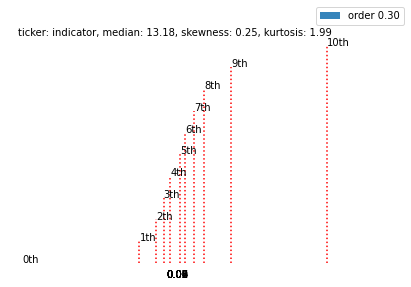

293


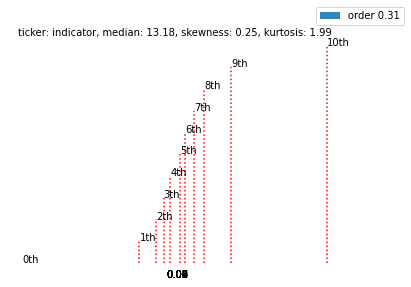

293


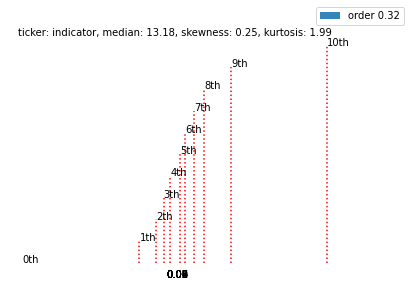

293


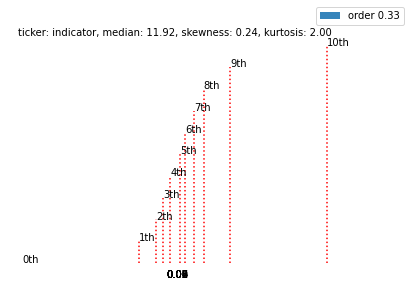

293


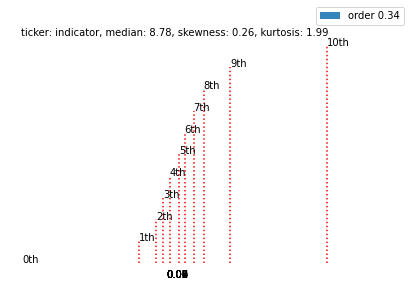

293


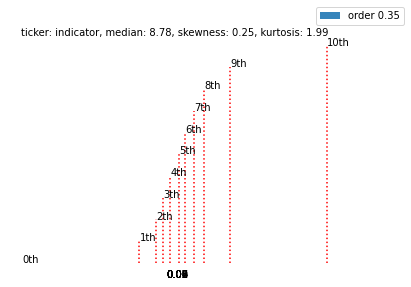

293


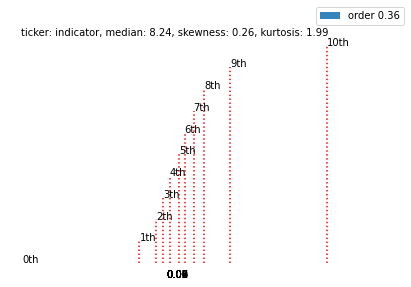

294


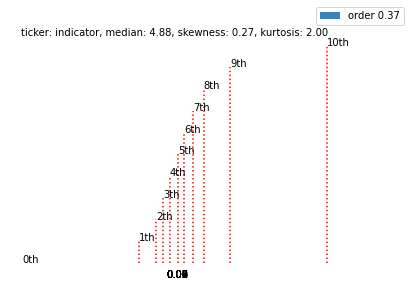

294


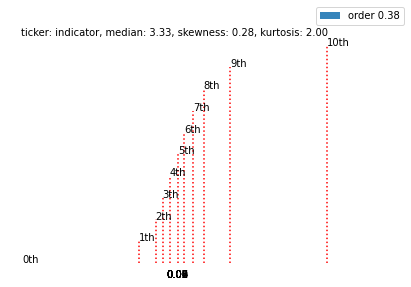

294


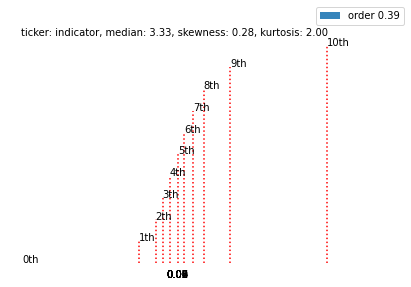

294


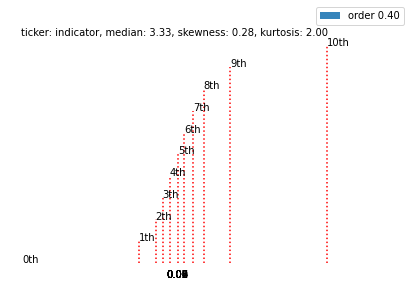

294


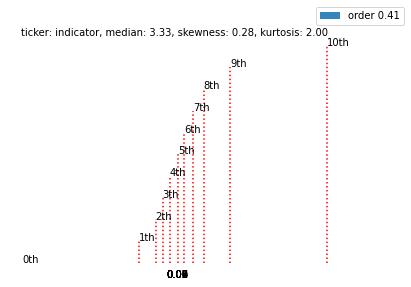

294


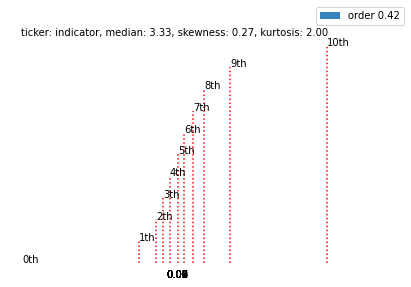

294


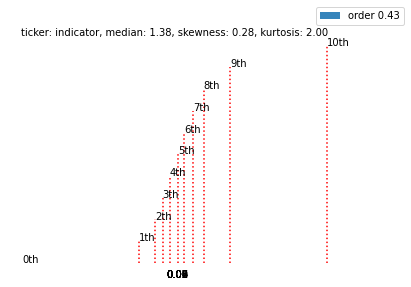

294


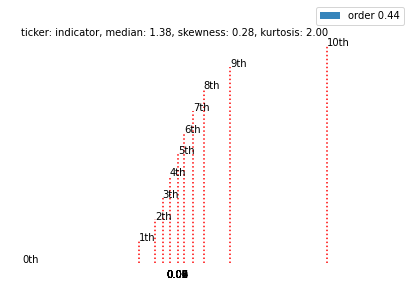

294


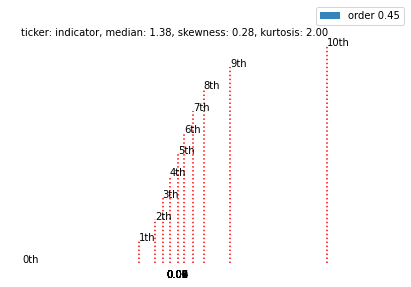

294


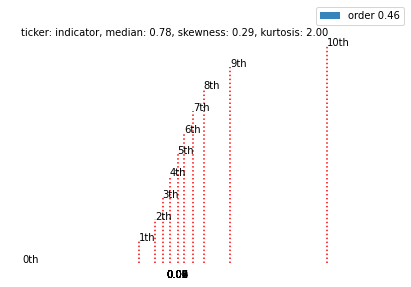

295


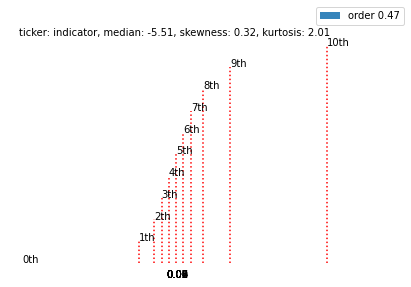

295


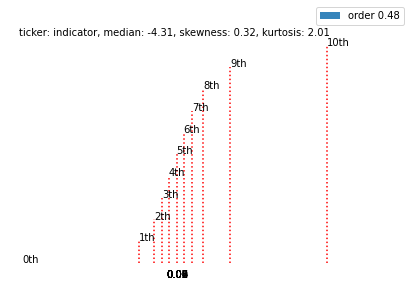

295


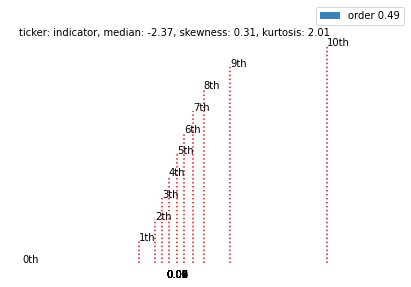

295


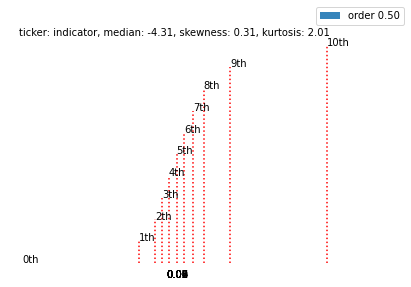

295


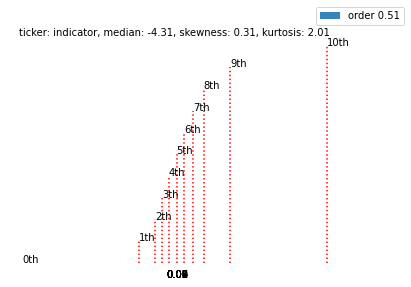

295


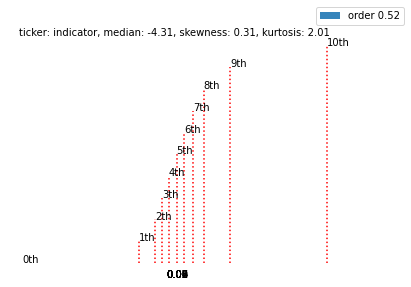

295


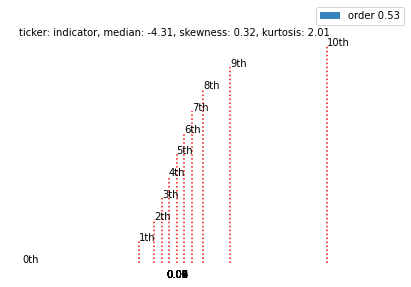

296


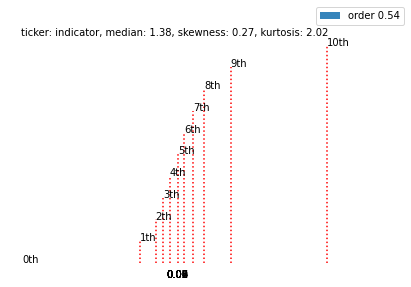

296


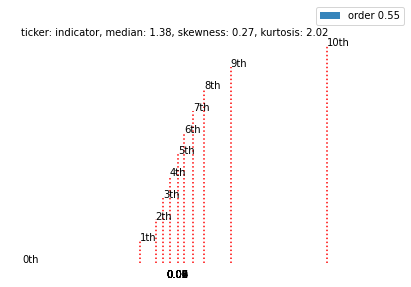

296


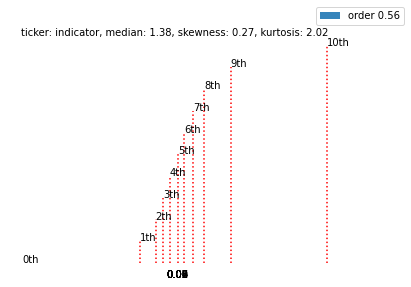

296


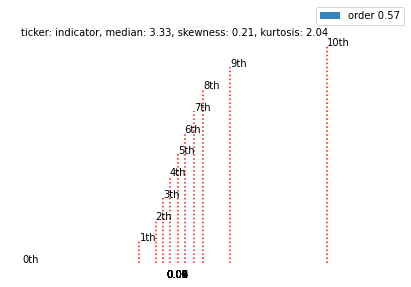

296


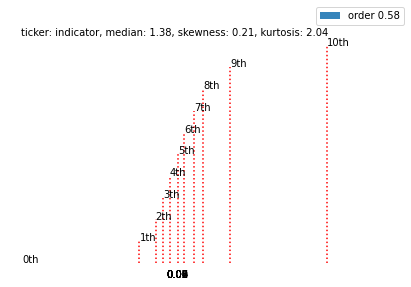

296


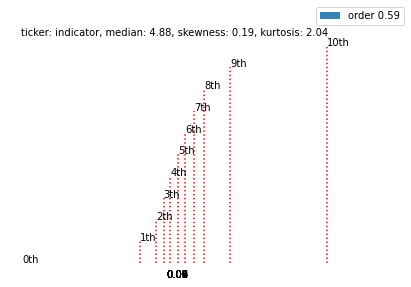

296


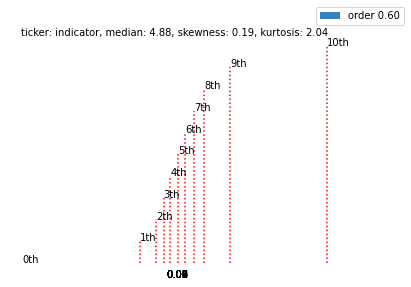

296


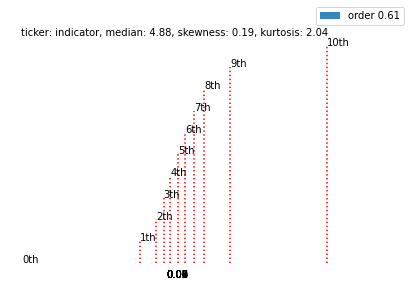

296


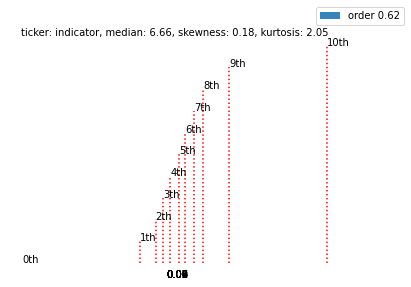

296


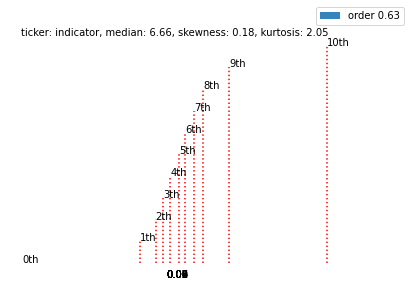

296


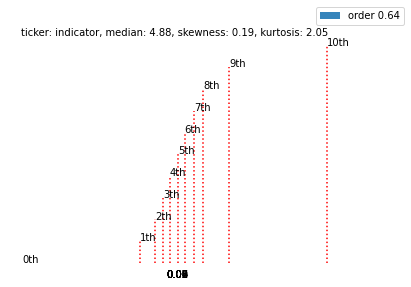

296


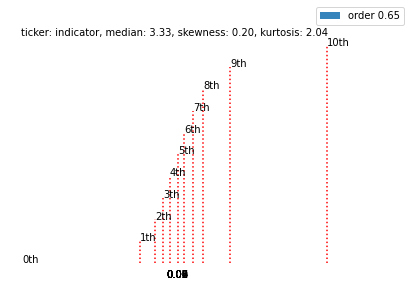

296


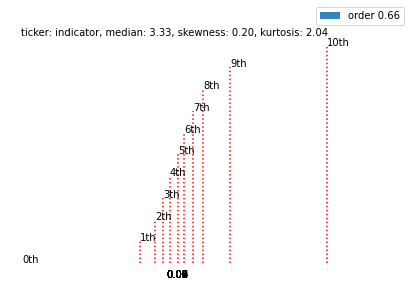

296


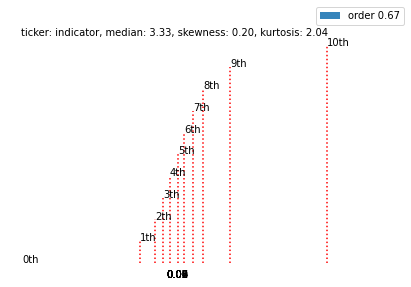

296


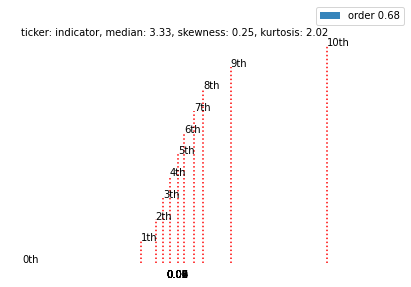

296


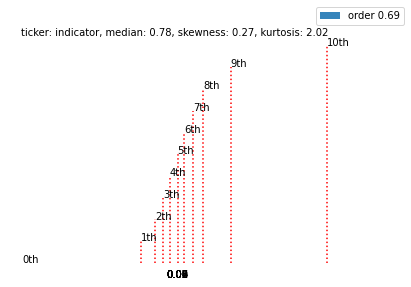

296


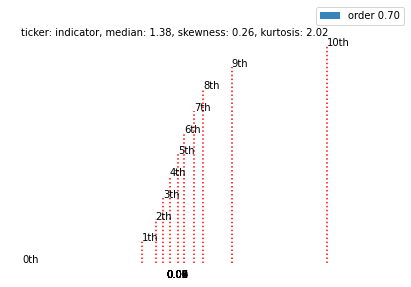

296


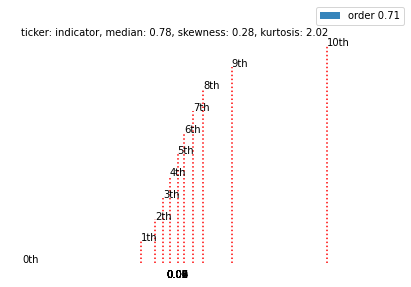

296


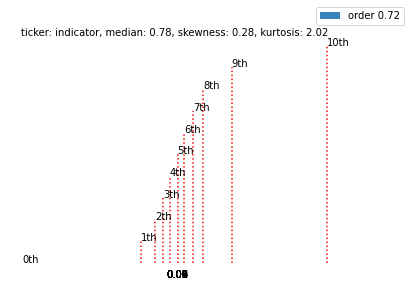

296


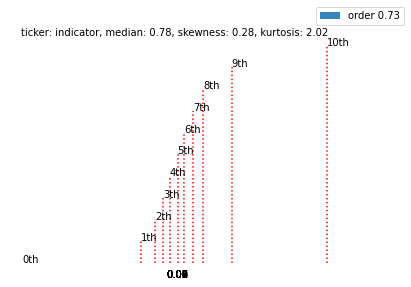

296


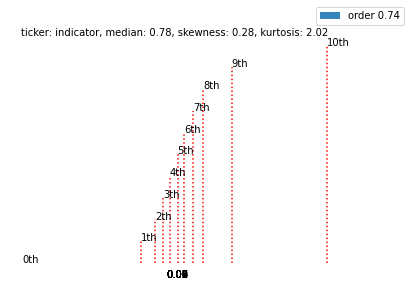

296


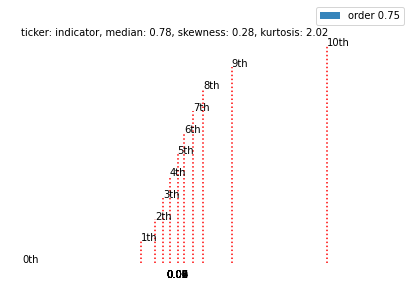

296


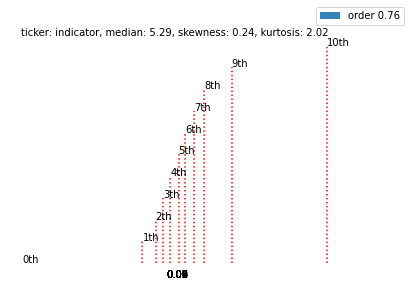

296


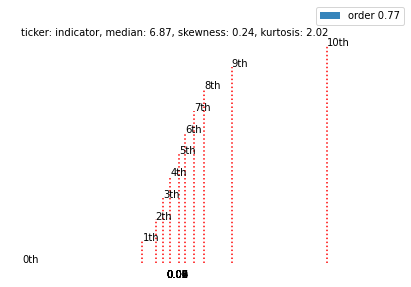

296


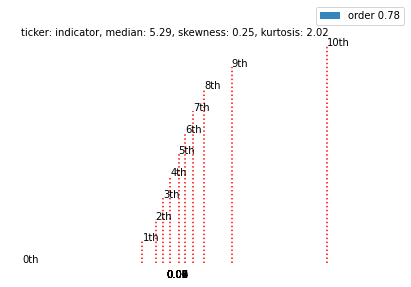

296


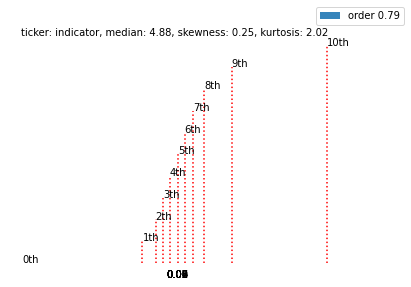

296


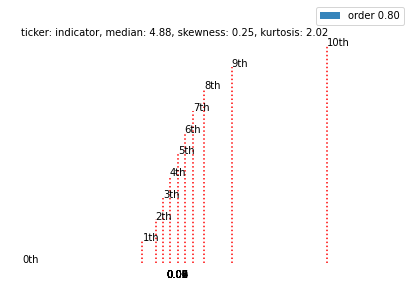

296


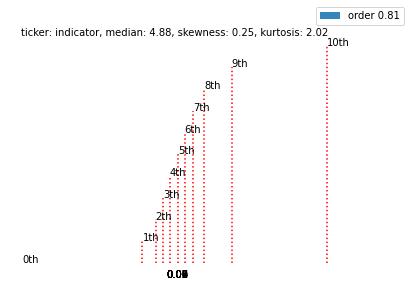

296


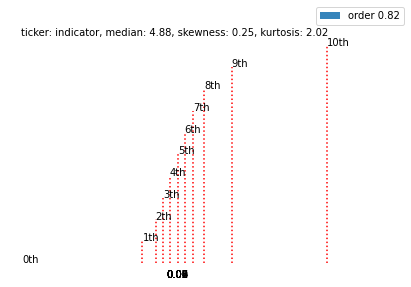

297


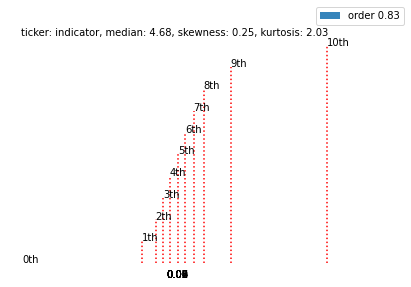

297


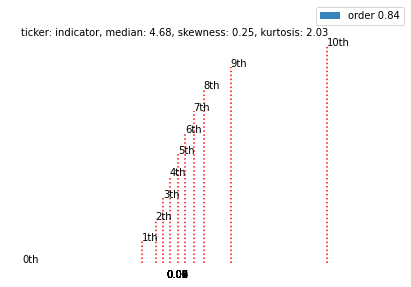

297


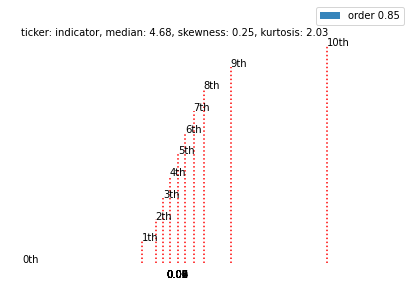

297


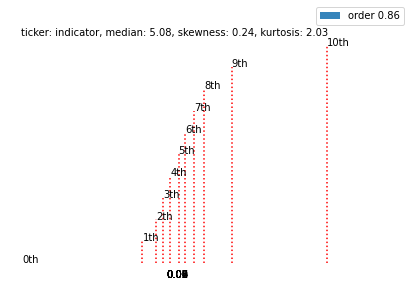

297


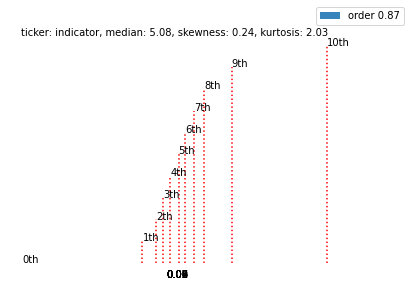

297


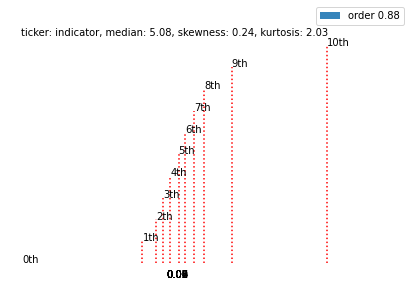

298


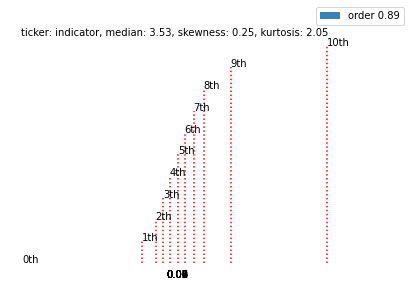

298


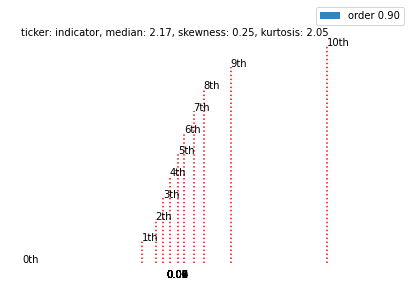

298


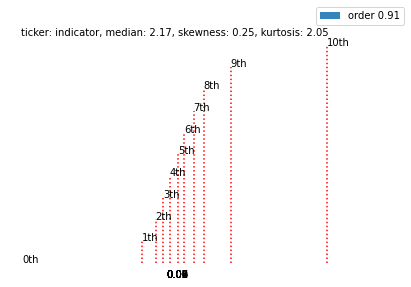

298


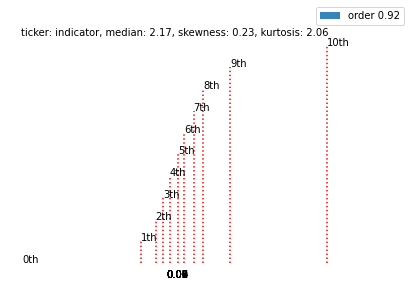

298


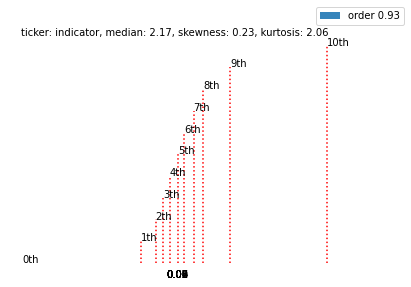

299


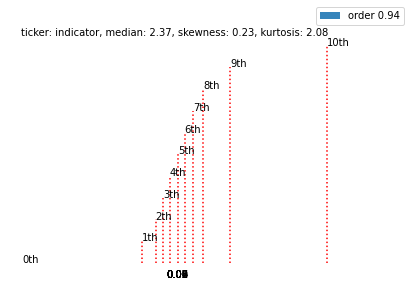

299


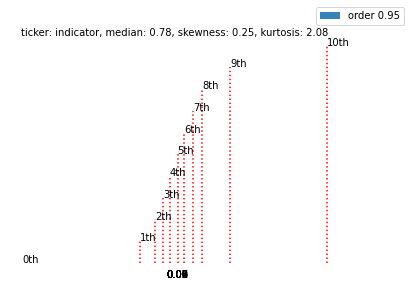

299


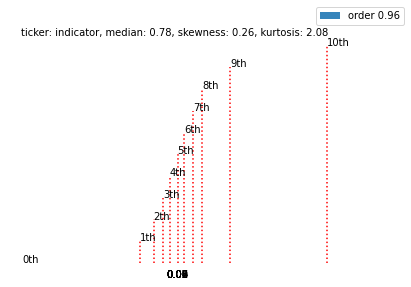

299


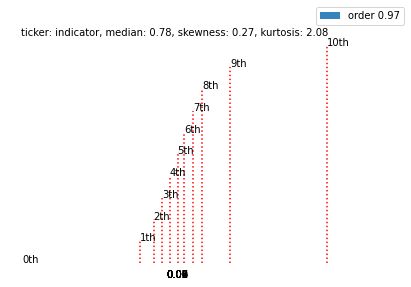

300


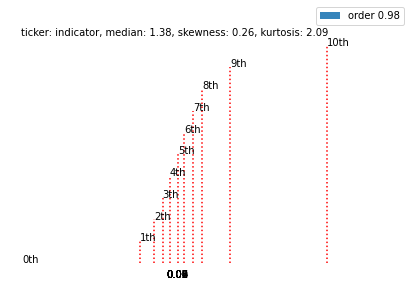

300


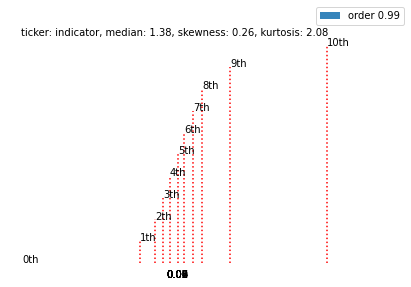

300


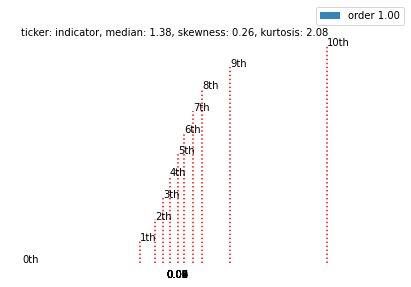

In [38]:
dataToPLot = []
ordersToExplore = orders

for ticker in tickers: 
    for window in [4]:
        for k, order in enumerate(ordersToExplore):
            x = overallScores.loc[(overallScores.order == order) & (overallScores.window == window) & (overallScores.ticker == ticker), 'strategyReturn']
            nObservations = x.count()
            print(nObservations)
            if nObservations < 10:
                continue
            skewness = x.skew()
            kurtosis = x.kurtosis()
            standardDeviation = x.std()
            median = x.median()
            dataToPLot.append(x)
            dataToPLot.append({'window':window, 'order':order, 'data':x})

            # Calculate percentiles
            quants = [[x.quantile(float(k/10)), 1., float(k/(10))] for k in range(0, 11)]

            
            fig, ax = plt.subplots(figsize = (6,4))
            #ax = plt.gca()
            ax.set_ylim([0, nObservations/10])
            # Plot the lines with a loop
            ax.set_yticklabels([])
            ax.set_ylabel("")
            for k, i in enumerate(quants):
                ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = 'r')
                ax.text(i[0]-.01, nObservations * i[2] / 10, f'{k}th', size = 10, alpha = 1)

            if 'JPY' in ticker:
                plt.xticks(np.arange(0, 10, step=0.1))
                bins = np.linspace(0, 1, int(100))
            else:
                plt.xticks(np.arange(0, .1, step=0.01))
                bins = np.linspace(0, .1, int(np.sqrt(nObservations)))
            plt.hist(x, bins, alpha=0.9, label=f'order {order:.2f}')    
            plt.legend(loc='upper right', bbox_to_anchor = (1.2, 1.2))
            #plt.title(f'median: {median:.2f}, skewness: {skewness:.2f}, kurtosis: {kurtosis:.2f}')

            # Overall
            ax.grid(False)
            ax.set_title(f'ticker: {ticker}, median: {median:.2f}, skewness: {skewness:.2f}, kurtosis: {kurtosis:.2f}', size = 10, pad = 10)

                # Remove ticks and spines
            ax.tick_params(left = False, bottom = False)
            for ax, spine in ax.spines.items():
                spine.set_visible(False)
            plt.show()

In [ ]:
for dictElement in mlModels:
    win = dictElement['window']
    ord = dictElement['order']
    mdlName = f'btc_mdl_trained_from_2022-04-16_to_2022-04-30_window_{str(win).zfill(2)}_order_{ord:.2f}_date_' + datetime.datetime.strftime(datetime.date.today(), '%Y-%m-%d')
    pickle.dump(lrm, open(f'../ml_models/btc_mdl_train_2022-04-16_2022-04-30_window8_ts_{mdlName}.sav', 'wb'))
    print(mdlName)